In [1]:
import numpy as np
import scipy
import sys
import os
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import cm,colors

In [2]:
from model import Model
from model import convertToOneHot, DataSet_meta

## Linear synthetic data generation

Group 1: $X$ ~ $N(1,0.5)$,  $Y = -2X_1 + X_2 - 0.5X_3$

Group 2: $X$ ~ $N(-1,0.5)$, $Y = -0.5X_3 + X_4 - 2X_5$



In [3]:
np.random.seed(34)

Xs1 = np.random.normal(loc=1,scale=0.5,size=(300,5))
Ys1 = -2*Xs1[:,0]+1*Xs1[:,1]-0.5*Xs1[:,2]

Xs2 = np.random.normal(loc=-1,scale=0.5,size=(300,5))
Ys2 = -0.5*Xs2[:,2]+1*Xs2[:,3]-2*Xs2[:,4]

In [4]:
X_data = np.concatenate((Xs1,Xs2),axis=0)
Y_data = np.concatenate((Ys1.reshape(-1,1),Ys2.reshape(-1,1)),axis=0)

In [5]:
Y_data = Y_data-Y_data.min()
Y_data=Y_data/Y_data.max()

In [6]:
# The ground truth group label of each sample
case_labels = np.concatenate((np.array([1]*300),np.array([2]*300)))

In [7]:
Y_data = np.concatenate((Y_data,case_labels.reshape(-1,1)),axis=1)

In [8]:
# 10% for validation, 10% for test 
X_train,X_remain,yc_train,yc_remain = train_test_split(X_data,Y_data,train_size=0.8,shuffle=True,random_state=34)
X_valid,X_test,yc_valid,yc_test = train_test_split(X_remain,yc_remain,train_size=0.5,shuffle=True,random_state=34)

In [9]:
# Only 10 samples used for training
X_train,_,yc_train,_ = train_test_split(X_train,yc_train,train_size=10,shuffle=True,random_state=34)

In [10]:
print("Sample sizes:")
print(X_train.shape[0],X_valid.shape[0],X_test.shape[0])

Sample sizes:
10 60 60


In [11]:
y_train = yc_train[:,0].reshape(-1,1)
y_valid = yc_valid[:,0].reshape(-1,1)
y_test = yc_test[:,0].reshape(-1,1)

In [12]:
train_label = yc_train[:,1]
valid_label = yc_valid[:,1]
test_label= yc_test[:,1]

In [13]:
Counter(train_label)

Counter({2.0: 6, 1.0: 4})

In [14]:
Counter(valid_label)

Counter({2.0: 29, 1.0: 31})

In [16]:
dataset = DataSet_meta(**{'_data':X_train, '_labels':y_train,'_meta':y_train,
                '_valid_data':X_valid, '_valid_labels':y_valid,'_valid_meta':y_valid,
                '_test_data':X_test, '_test_labels':y_test,'_test_meta':y_test})

In [17]:
# reference ground truth feature matrix (training/test)
ref_feat_mat_train = np.array([[1,1,1,0,0] if label == 1 else [0,0,1,1,1] for label in train_label])
ref_feat_mat_test = np.array([[1,1,1,0,0] if label == 1 else [0,0,1,1,1] for label in test_label])

## Run LLSPIN

In [30]:
# hyper-parameter specification
model_params = {     
    "input_node" : X_train.shape[1],       # input dimension for the prediction network
    "hidden_layers_node" : [100,100,10,1], # number of nodes for each hidden layer of the prediction net
    "output_node" : 1,                     # number of nodes for the output layer of the prediction net
    "feature_selection" : True,            # if using the gating net
    "gating_net_hidden_layers_node": [10], # number of nodes for each hidden layer of the gating net
    "display_step" : 500                   # number of epochs to output info
}
model_params['activation_pred']= 'none' # linear prediction
model_params['activation_gating'] = 'tanh'

model_params['batch_normalization'] = 'False'

In [31]:
training_params = {
    'batch_size':X_train.shape[0]
} 

In [32]:
# objective function for optuna hyper-parameter optimization
def llspin_objective(trial):  
    global model
    
    # hyper-parameter to optimize: lambda, learning rate, number of epochs
    model_params['lam'] = trial.suggest_loguniform('lam',1e-3,1e-2)
    training_params['lr'] = trial.suggest_loguniform('learning_rate', 1e-2, 2e-1)
    training_params['num_epoch'] = trial.suggest_categorical('num_epoch', [2000,5000,10000,15000])

    # specify the model with these parameters and train the model
    model = Model(**model_params)
    train_acces, train_losses, val_acces, val_losses = model.train(dataset=dataset,**training_params)

    print("In trial:---------------------")
    val_prediction = model.test(X_valid)[0]
    mse = mean_squared_error(y_valid.reshape(-1),val_prediction.reshape(-1))
    print("validation mse: {}".format(mse))
    
    loss= mse
            
    return loss
        
def callback(study,trial):
    global best_model
    if study.best_trial == trial:
        best_model = model

In [33]:
# optimize the model via Optuna and obtain the best model with smallest validation mse
best_model = None
model = None
study = optuna.create_study(pruner=None)
study.optimize(llspin_objective, n_trials=100, callbacks=[callback])

[I 2022-01-27 04:20:20,861] A new study created in memory with name: no-name-231f7775-9e79-4436-8604-34bb9f5953d2


num_samples : 10
Epoch: 500 train loss=0.019199613 valid loss= 0.014349099
Epoch: 1000 train loss=0.018299948 valid loss= 0.013251478
Epoch: 1500 train loss=0.018981043 valid loss= 0.012919768


[I 2022-01-27 04:20:41,968] Trial 0 finished with value: 0.005639222691545177 and parameters: {'lam': 0.00976368643084559, 'learning_rate': 0.0320124089168281, 'num_epoch': 2000}. Best is trial 0 with value: 0.005639222691545177.


Epoch: 2000 train loss=0.024905063 valid loss= 0.013935876
Optimization Finished!
test loss: 0.01478402130305767, test acc: 1.0
In trial:---------------------
validation mse: 0.005639222691545177
num_samples : 10
Epoch: 500 train loss=0.024651777 valid loss= 0.008461524
Epoch: 1000 train loss=0.007127225 valid loss= 0.008032663
Epoch: 1500 train loss=0.006645962 valid loss= 0.007861067
Epoch: 2000 train loss=0.013712140 valid loss= 0.007685911
Epoch: 2500 train loss=0.013006258 valid loss= 0.007303611
Epoch: 3000 train loss=0.008046509 valid loss= 0.007826992
Epoch: 3500 train loss=0.009211547 valid loss= 0.006861527
Epoch: 4000 train loss=0.004579989 valid loss= 0.006721389
Epoch: 4500 train loss=0.005859715 valid loss= 0.006620081
Epoch: 5000 train loss=0.004934237 valid loss= 0.006428248
Epoch: 5500 train loss=0.003499446 valid loss= 0.006333012
Epoch: 6000 train loss=0.005556284 valid loss= 0.006069766
Epoch: 6500 train loss=0.005926464 valid loss= 0.005879606
Epoch: 7000 train los

[I 2022-01-27 04:22:19,917] Trial 1 finished with value: 0.003529721426480185 and parameters: {'lam': 0.0018503755211600663, 'learning_rate': 0.026064922715766485, 'num_epoch': 10000}. Best is trial 1 with value: 0.003529721426480185.


Epoch: 10000 train loss=0.003265945 valid loss= 0.005195721
Optimization Finished!
test loss: 0.005266119260340929, test acc: 1.0
In trial:---------------------
validation mse: 0.003529721426480185
num_samples : 10
Epoch: 500 train loss=0.016604269 valid loss= 0.008435335
Epoch: 1000 train loss=0.010373626 valid loss= 0.007585984
Epoch: 1500 train loss=0.008601937 valid loss= 0.007588248
Epoch: 2000 train loss=0.008194674 valid loss= 0.007450633
Epoch: 2500 train loss=0.007638324 valid loss= 0.007638639
Epoch: 3000 train loss=0.008222405 valid loss= 0.007040053
Epoch: 3500 train loss=0.009674870 valid loss= 0.006922674
Epoch: 4000 train loss=0.005358696 valid loss= 0.007328531
Epoch: 4500 train loss=0.009904248 valid loss= 0.006832212
Epoch: 5000 train loss=0.004833036 valid loss= 0.006587625
Epoch: 5500 train loss=0.005995873 valid loss= 0.005847696
Epoch: 6000 train loss=0.005611592 valid loss= 0.006292931
Epoch: 6500 train loss=0.007397601 valid loss= 0.005366785
Epoch: 7000 train l

[I 2022-01-27 04:23:56,427] Trial 2 finished with value: 0.002505764457827466 and parameters: {'lam': 0.0015878770588951567, 'learning_rate': 0.02799719973388292, 'num_epoch': 10000}. Best is trial 2 with value: 0.002505764457827466.


Epoch: 10000 train loss=0.004826409 valid loss= 0.003782789
Optimization Finished!
test loss: 0.003950268495827913, test acc: 1.0
In trial:---------------------
validation mse: 0.002505764457827466
num_samples : 10
Epoch: 500 train loss=0.015926231 valid loss= 0.013816646
Epoch: 1000 train loss=0.012191494 valid loss= 0.010602374
Epoch: 1500 train loss=0.014433151 valid loss= 0.010391161
Epoch: 2000 train loss=0.008959000 valid loss= 0.010296751
Epoch: 2500 train loss=0.009011566 valid loss= 0.010846651
Epoch: 3000 train loss=0.008208347 valid loss= 0.010457069
Epoch: 3500 train loss=0.007084726 valid loss= 0.010091584
Epoch: 4000 train loss=0.012326405 valid loss= 0.009947291
Epoch: 4500 train loss=0.008750997 valid loss= 0.010000524


[I 2022-01-27 04:24:46,299] Trial 3 finished with value: 0.004325573666880858 and parameters: {'lam': 0.009399983493436131, 'learning_rate': 0.11872534816754728, 'num_epoch': 5000}. Best is trial 2 with value: 0.002505764457827466.


Epoch: 5000 train loss=0.007929506 valid loss= 0.010068219
Optimization Finished!
test loss: 0.010199256241321564, test acc: 1.0
In trial:---------------------
validation mse: 0.004325573666880858
num_samples : 10
Epoch: 500 train loss=0.018594807 valid loss= 0.009608831
Epoch: 1000 train loss=0.011996957 valid loss= 0.008956482
Epoch: 1500 train loss=0.018249685 valid loss= 0.008811019
Epoch: 2000 train loss=0.016814891 valid loss= 0.008528588
Epoch: 2500 train loss=0.010693766 valid loss= 0.008615874
Epoch: 3000 train loss=0.015547372 valid loss= 0.007839699
Epoch: 3500 train loss=0.008855030 valid loss= 0.008493962
Epoch: 4000 train loss=0.008670651 valid loss= 0.007480389
Epoch: 4500 train loss=0.005281859 valid loss= 0.008418596
Epoch: 5000 train loss=0.013199024 valid loss= 0.008433678
Epoch: 5500 train loss=0.010321228 valid loss= 0.007744010
Epoch: 6000 train loss=0.007995393 valid loss= 0.007409426
Epoch: 6500 train loss=0.010843451 valid loss= 0.006654294
Epoch: 7000 train lo

[I 2022-01-27 04:27:12,411] Trial 4 finished with value: 0.0038582939170120896 and parameters: {'lam': 0.002280414670384256, 'learning_rate': 0.019835751546484506, 'num_epoch': 15000}. Best is trial 2 with value: 0.002505764457827466.


Epoch: 15000 train loss=0.003547115 valid loss= 0.005548670
Optimization Finished!
test loss: 0.005675830878317356, test acc: 1.0
In trial:---------------------
validation mse: 0.0038582939170120896
num_samples : 10
Epoch: 500 train loss=0.026117910 valid loss= 0.014746122
Epoch: 1000 train loss=0.012349450 valid loss= 0.014890019
Epoch: 1500 train loss=0.011446623 valid loss= 0.012851140


[I 2022-01-27 04:27:33,867] Trial 5 finished with value: 0.003920789104563355 and parameters: {'lam': 0.008761010834960906, 'learning_rate': 0.0640420520500171, 'num_epoch': 2000}. Best is trial 2 with value: 0.002505764457827466.


Epoch: 2000 train loss=0.010681633 valid loss= 0.010645153
Optimization Finished!
test loss: 0.010874215513467789, test acc: 1.0
In trial:---------------------
validation mse: 0.003920789104563355
num_samples : 10
Epoch: 500 train loss=0.015547818 valid loss= 0.010715184
Epoch: 1000 train loss=0.013691332 valid loss= 0.010132811
Epoch: 1500 train loss=0.015674392 valid loss= 0.010044904


[I 2022-01-27 04:27:55,210] Trial 6 finished with value: 0.0068103231666390525 and parameters: {'lam': 0.003552463032161061, 'learning_rate': 0.02272728124992357, 'num_epoch': 2000}. Best is trial 2 with value: 0.002505764457827466.


Epoch: 2000 train loss=0.012709934 valid loss= 0.009930237
Optimization Finished!
test loss: 0.012165794149041176, test acc: 1.0
In trial:---------------------
validation mse: 0.0068103231666390525
num_samples : 10
Epoch: 500 train loss=0.011754628 valid loss= 0.008300214
Epoch: 1000 train loss=0.009094238 valid loss= 0.007877668
Epoch: 1500 train loss=0.008705718 valid loss= 0.007849361
Epoch: 2000 train loss=0.014591634 valid loss= 0.008352211
Epoch: 2500 train loss=0.011238880 valid loss= 0.008027209
Epoch: 3000 train loss=0.007111190 valid loss= 0.008149890
Epoch: 3500 train loss=0.006258218 valid loss= 0.007758787
Epoch: 4000 train loss=0.006375549 valid loss= 0.007407881
Epoch: 4500 train loss=0.013159290 valid loss= 0.007895548
Epoch: 5000 train loss=0.006855285 valid loss= 0.007696294
Epoch: 5500 train loss=0.008253125 valid loss= 0.007295419
Epoch: 6000 train loss=0.005449088 valid loss= 0.008061192
Epoch: 6500 train loss=0.008655818 valid loss= 0.007994399
Epoch: 7000 train l

[I 2022-01-27 04:30:19,892] Trial 7 finished with value: 0.005736672047566734 and parameters: {'lam': 0.0014336496195466997, 'learning_rate': 0.012352657127979932, 'num_epoch': 15000}. Best is trial 2 with value: 0.002505764457827466.


Epoch: 15000 train loss=0.007626234 valid loss= 0.007006505
Optimization Finished!
test loss: 0.006598735228180885, test acc: 1.0
In trial:---------------------
validation mse: 0.005736672047566734
num_samples : 10
Epoch: 500 train loss=0.025691304 valid loss= 0.015167283
Epoch: 1000 train loss=0.023994733 valid loss= 0.014489707
Epoch: 1500 train loss=0.020816974 valid loss= 0.013888052
Epoch: 2000 train loss=0.018975846 valid loss= 0.013462206
Epoch: 2500 train loss=0.018224929 valid loss= 0.012480568
Epoch: 3000 train loss=0.011714961 valid loss= 0.010896111
Epoch: 3500 train loss=0.009394361 valid loss= 0.010122527
Epoch: 4000 train loss=0.011147059 valid loss= 0.009842014
Epoch: 4500 train loss=0.014282737 valid loss= 0.009682556
Epoch: 5000 train loss=0.009056992 valid loss= 0.009790011
Epoch: 5500 train loss=0.014135309 valid loss= 0.009335763
Epoch: 6000 train loss=0.015748007 valid loss= 0.009277957
Epoch: 6500 train loss=0.011795518 valid loss= 0.009181453
Epoch: 7000 train l

[I 2022-01-27 04:32:47,308] Trial 8 finished with value: 0.0020552688292528884 and parameters: {'lam': 0.009487439861077389, 'learning_rate': 0.030995029182938123, 'num_epoch': 15000}. Best is trial 8 with value: 0.0020552688292528884.


Epoch: 15000 train loss=0.007475052 valid loss= 0.007784557
Optimization Finished!
test loss: 0.0074676829390227795, test acc: 1.0
In trial:---------------------
validation mse: 0.0020552688292528884
num_samples : 10
Epoch: 500 train loss=0.016302435 valid loss= 0.008237323
Epoch: 1000 train loss=0.014989380 valid loss= 0.007706359
Epoch: 1500 train loss=0.008566581 valid loss= 0.007512718
Epoch: 2000 train loss=0.004233418 valid loss= 0.007124386
Epoch: 2500 train loss=0.013569580 valid loss= 0.005970894
Epoch: 3000 train loss=0.006678679 valid loss= 0.006002773
Epoch: 3500 train loss=0.009474367 valid loss= 0.005645868
Epoch: 4000 train loss=0.002310268 valid loss= 0.005600758
Epoch: 4500 train loss=0.008961802 valid loss= 0.004606818
Epoch: 5000 train loss=0.007016646 valid loss= 0.004273815
Epoch: 5500 train loss=0.012681609 valid loss= 0.003818060
Epoch: 6000 train loss=0.008963226 valid loss= 0.003770268
Epoch: 6500 train loss=0.003469034 valid loss= 0.003726908
Epoch: 7000 train

[I 2022-01-27 04:35:10,766] Trial 9 finished with value: 0.0028008236305818914 and parameters: {'lam': 0.001553727200218501, 'learning_rate': 0.024335435426449954, 'num_epoch': 15000}. Best is trial 8 with value: 0.0020552688292528884.


Epoch: 15000 train loss=0.003879391 valid loss= 0.003984013
Optimization Finished!
test loss: 0.004499207716435194, test acc: 1.0
In trial:---------------------
validation mse: 0.0028008236305818914
num_samples : 10
Epoch: 500 train loss=0.012384645 valid loss= 0.011740530
Epoch: 1000 train loss=0.011251997 valid loss= 0.012361117
Epoch: 1500 train loss=0.015822753 valid loss= 0.012495501
Epoch: 2000 train loss=0.009927279 valid loss= 0.012896901
Epoch: 2500 train loss=0.012879648 valid loss= 0.011836415
Epoch: 3000 train loss=0.006140682 valid loss= 0.011474397
Epoch: 3500 train loss=0.010885141 valid loss= 0.010400383
Epoch: 4000 train loss=0.009752354 valid loss= 0.010728915
Epoch: 4500 train loss=0.005989781 valid loss= 0.009495259


[I 2022-01-27 04:36:00,324] Trial 10 finished with value: 0.006025218616318714 and parameters: {'lam': 0.005311215554357117, 'learning_rate': 0.05736376209267282, 'num_epoch': 5000}. Best is trial 8 with value: 0.0020552688292528884.


Epoch: 5000 train loss=0.009454729 valid loss= 0.010336101
Optimization Finished!
test loss: 0.009951401501893997, test acc: 1.0
In trial:---------------------
validation mse: 0.006025218616318714
num_samples : 10
Epoch: 500 train loss=0.018473174 valid loss= 0.007923791
Epoch: 1000 train loss=0.017470745 valid loss= 0.007530995
Epoch: 1500 train loss=0.011854138 valid loss= 0.007497827
Epoch: 2000 train loss=0.024091605 valid loss= 0.007364745
Epoch: 2500 train loss=0.017291160 valid loss= 0.007203855
Epoch: 3000 train loss=0.012302106 valid loss= 0.006916594
Epoch: 3500 train loss=0.009726957 valid loss= 0.006820249
Epoch: 4000 train loss=0.021045690 valid loss= 0.006774708
Epoch: 4500 train loss=0.012584156 valid loss= 0.006711405
Epoch: 5000 train loss=0.009977190 valid loss= 0.006605555
Epoch: 5500 train loss=0.008489206 valid loss= 0.006416754
Epoch: 6000 train loss=0.019152135 valid loss= 0.006352305
Epoch: 6500 train loss=0.009704054 valid loss= 0.006728464
Epoch: 7000 train lo

[I 2022-01-27 04:37:38,538] Trial 11 finished with value: 0.005016395722700979 and parameters: {'lam': 0.0011391091582322957, 'learning_rate': 0.010040556322182259, 'num_epoch': 10000}. Best is trial 8 with value: 0.0020552688292528884.


Epoch: 10000 train loss=0.006740719 valid loss= 0.006012139
Optimization Finished!
test loss: 0.00624422449618578, test acc: 1.0
In trial:---------------------
validation mse: 0.005016395722700979
num_samples : 10
Epoch: 500 train loss=0.013805656 valid loss= 0.008572465
Epoch: 1000 train loss=0.016447563 valid loss= 0.007634606
Epoch: 1500 train loss=0.007146989 valid loss= 0.007118715
Epoch: 2000 train loss=0.014100665 valid loss= 0.005590839
Epoch: 2500 train loss=0.008677365 valid loss= 0.005250604
Epoch: 3000 train loss=0.004124018 valid loss= 0.005167339
Epoch: 3500 train loss=0.003466857 valid loss= 0.005600278
Epoch: 4000 train loss=0.003585803 valid loss= 0.005268050
Epoch: 4500 train loss=0.007784759 valid loss= 0.005058754
Epoch: 5000 train loss=0.004249450 valid loss= 0.005216352
Epoch: 5500 train loss=0.005377300 valid loss= 0.004969540
Epoch: 6000 train loss=0.007855222 valid loss= 0.004846795
Epoch: 6500 train loss=0.004097870 valid loss= 0.005001709
Epoch: 7000 train lo

[I 2022-01-27 04:39:17,375] Trial 12 finished with value: 0.0027598389851334498 and parameters: {'lam': 0.003163453442066962, 'learning_rate': 0.038752034357938885, 'num_epoch': 10000}. Best is trial 8 with value: 0.0020552688292528884.


Epoch: 10000 train loss=0.007706853 valid loss= 0.004857872
Optimization Finished!
test loss: 0.004580171313136816, test acc: 1.0
In trial:---------------------
validation mse: 0.0027598389851334498
num_samples : 10
Epoch: 500 train loss=0.014119195 valid loss= 0.011743631
Epoch: 1000 train loss=0.008969542 valid loss= 0.011147453
Epoch: 1500 train loss=0.005952419 valid loss= 0.011337452
Epoch: 2000 train loss=0.008160462 valid loss= 0.010423305
Epoch: 2500 train loss=0.012810803 valid loss= 0.010213468
Epoch: 3000 train loss=0.006605437 valid loss= 0.009824554
Epoch: 3500 train loss=0.005438136 valid loss= 0.009240935
Epoch: 4000 train loss=0.006431568 valid loss= 0.009461473
Epoch: 4500 train loss=0.021043014 valid loss= 0.007553545
Epoch: 5000 train loss=0.003906779 valid loss= 0.006766297
Epoch: 5500 train loss=0.007609342 valid loss= 0.006153926
Epoch: 6000 train loss=0.004212425 valid loss= 0.005957434
Epoch: 6500 train loss=0.003338923 valid loss= 0.005856100
Epoch: 7000 train 

[I 2022-01-27 04:41:43,993] Trial 13 finished with value: 0.002278732912322766 and parameters: {'lam': 0.0048028778394179185, 'learning_rate': 0.08649382256713707, 'num_epoch': 15000}. Best is trial 8 with value: 0.0020552688292528884.


Epoch: 15000 train loss=0.004597039 valid loss= 0.005131766
Optimization Finished!
test loss: 0.004909774288535118, test acc: 1.0
In trial:---------------------
validation mse: 0.002278732912322766
num_samples : 10
Epoch: 500 train loss=0.013620736 valid loss= 0.010592081
Epoch: 1000 train loss=0.011332199 valid loss= 0.008304361
Epoch: 1500 train loss=0.006612793 valid loss= 0.007018578
Epoch: 2000 train loss=0.008715365 valid loss= 0.006834486
Epoch: 2500 train loss=0.005999931 valid loss= 0.007065854
Epoch: 3000 train loss=0.004669023 valid loss= 0.006858072
Epoch: 3500 train loss=0.010844226 valid loss= 0.006519024
Epoch: 4000 train loss=0.009278221 valid loss= 0.006345048
Epoch: 4500 train loss=0.006516357 valid loss= 0.006140301
Epoch: 5000 train loss=0.004293240 valid loss= 0.006449474
Epoch: 5500 train loss=0.003872446 valid loss= 0.005934830
Epoch: 6000 train loss=0.004504785 valid loss= 0.005756903
Epoch: 6500 train loss=0.004573619 valid loss= 0.005710589
Epoch: 7000 train l

[I 2022-01-27 04:44:12,042] Trial 14 finished with value: 0.0023826255264126008 and parameters: {'lam': 0.005687511640516466, 'learning_rate': 0.1225918244925349, 'num_epoch': 15000}. Best is trial 8 with value: 0.0020552688292528884.


Epoch: 15000 train loss=0.009558793 valid loss= 0.005713193
Optimization Finished!
test loss: 0.005439539905637503, test acc: 1.0
In trial:---------------------
validation mse: 0.0023826255264126008
num_samples : 10
Epoch: 500 train loss=0.012348983 valid loss= 0.009663019
Epoch: 1000 train loss=0.004729598 valid loss= 0.007510608
Epoch: 1500 train loss=0.007685121 valid loss= 0.007028232
Epoch: 2000 train loss=0.004432524 valid loss= 0.006122957
Epoch: 2500 train loss=0.005640271 valid loss= 0.005932366
Epoch: 3000 train loss=0.004100299 valid loss= 0.005930931
Epoch: 3500 train loss=0.004974986 valid loss= 0.006139151
Epoch: 4000 train loss=0.003992824 valid loss= 0.006003256
Epoch: 4500 train loss=0.005600871 valid loss= 0.005718571
Epoch: 5000 train loss=0.006543048 valid loss= 0.005836674
Epoch: 5500 train loss=0.005199686 valid loss= 0.006163474
Epoch: 6000 train loss=0.004621949 valid loss= 0.005758461
Epoch: 6500 train loss=0.003998705 valid loss= 0.006167964
Epoch: 7000 train 

[I 2022-01-27 04:46:37,951] Trial 15 finished with value: 0.002156972493338465 and parameters: {'lam': 0.006024998771965476, 'learning_rate': 0.1879790793434074, 'num_epoch': 15000}. Best is trial 8 with value: 0.0020552688292528884.


Epoch: 15000 train loss=0.003884946 valid loss= 0.005652872
Optimization Finished!
test loss: 0.0054588401690125465, test acc: 1.0
In trial:---------------------
validation mse: 0.002156972493338465
num_samples : 10
Epoch: 500 train loss=0.012664422 valid loss= 0.011611437
Epoch: 1000 train loss=0.017754629 valid loss= 0.010974564
Epoch: 1500 train loss=0.009454953 valid loss= 0.009932226
Epoch: 2000 train loss=0.027567711 valid loss= 0.009038283
Epoch: 2500 train loss=0.010167108 valid loss= 0.008432524
Epoch: 3000 train loss=0.006720756 valid loss= 0.008380682
Epoch: 3500 train loss=0.006957921 valid loss= 0.008384150
Epoch: 4000 train loss=0.010070449 valid loss= 0.008683551
Epoch: 4500 train loss=0.008857344 valid loss= 0.008531934
Epoch: 5000 train loss=0.007353094 valid loss= 0.008825377
Epoch: 5500 train loss=0.006609284 valid loss= 0.008662320
Epoch: 6000 train loss=0.007601583 valid loss= 0.008821165
Epoch: 6500 train loss=0.010339156 valid loss= 0.008594931
Epoch: 7000 train 

[I 2022-01-27 04:49:03,983] Trial 16 finished with value: 0.00414928586605962 and parameters: {'lam': 0.007237755227911754, 'learning_rate': 0.04934921758323269, 'num_epoch': 15000}. Best is trial 8 with value: 0.0020552688292528884.


Epoch: 15000 train loss=0.007068089 valid loss= 0.008587660
Optimization Finished!
test loss: 0.008538863621652126, test acc: 1.0
In trial:---------------------
validation mse: 0.00414928586605962
num_samples : 10
Epoch: 500 train loss=0.017979104 valid loss= 0.009765003
Epoch: 1000 train loss=0.006244401 valid loss= 0.006491535
Epoch: 1500 train loss=0.004748368 valid loss= 0.005620504
Epoch: 2000 train loss=0.008779209 valid loss= 0.005311439
Epoch: 2500 train loss=0.005248347 valid loss= 0.005053348
Epoch: 3000 train loss=0.003643277 valid loss= 0.005375593
Epoch: 3500 train loss=0.005931168 valid loss= 0.004986197
Epoch: 4000 train loss=0.006509338 valid loss= 0.004374080
Epoch: 4500 train loss=0.006047685 valid loss= 0.004885972
Epoch: 5000 train loss=0.007183233 valid loss= 0.004892654
Epoch: 5500 train loss=0.005021241 valid loss= 0.005313436
Epoch: 6000 train loss=0.004924322 valid loss= 0.004649193
Epoch: 6500 train loss=0.003455240 valid loss= 0.005266941
Epoch: 7000 train lo

[I 2022-01-27 04:51:29,354] Trial 17 finished with value: 0.0022296549555165936 and parameters: {'lam': 0.004097335534015765, 'learning_rate': 0.16690511238852843, 'num_epoch': 15000}. Best is trial 8 with value: 0.0020552688292528884.


Epoch: 15000 train loss=0.003501724 valid loss= 0.004876586
Optimization Finished!
test loss: 0.004887956194579601, test acc: 1.0
In trial:---------------------
validation mse: 0.0022296549555165936
num_samples : 10
Epoch: 500 train loss=0.013054175 valid loss= 0.012235066
Epoch: 1000 train loss=0.013494435 valid loss= 0.011483297
Epoch: 1500 train loss=0.015952677 valid loss= 0.010757246
Epoch: 2000 train loss=0.016619559 valid loss= 0.010174665
Epoch: 2500 train loss=0.020996792 valid loss= 0.010244759
Epoch: 3000 train loss=0.014426891 valid loss= 0.009695059
Epoch: 3500 train loss=0.007461815 valid loss= 0.009763247
Epoch: 4000 train loss=0.010044305 valid loss= 0.009347591
Epoch: 4500 train loss=0.017147236 valid loss= 0.008848006
Epoch: 5000 train loss=0.007862199 valid loss= 0.008490168
Epoch: 5500 train loss=0.008271158 valid loss= 0.007859105
Epoch: 6000 train loss=0.009571459 valid loss= 0.008134141
Epoch: 6500 train loss=0.007608525 valid loss= 0.007706231
Epoch: 7000 train 

[I 2022-01-27 04:53:55,455] Trial 18 finished with value: 0.0023201418523358715 and parameters: {'lam': 0.00688028567521341, 'learning_rate': 0.0153894705166207, 'num_epoch': 15000}. Best is trial 8 with value: 0.0020552688292528884.


Epoch: 15000 train loss=0.011274176 valid loss= 0.007048293
Optimization Finished!
test loss: 0.006793521344661713, test acc: 1.0
In trial:---------------------
validation mse: 0.0023201418523358715
num_samples : 10
Epoch: 500 train loss=0.007953524 valid loss= 0.008531602
Epoch: 1000 train loss=0.008113540 valid loss= 0.008540146
Epoch: 1500 train loss=0.005753884 valid loss= 0.008138999
Epoch: 2000 train loss=0.006179729 valid loss= 0.007153749
Epoch: 2500 train loss=0.006859669 valid loss= 0.006662113
Epoch: 3000 train loss=0.013933437 valid loss= 0.006965524
Epoch: 3500 train loss=0.005050764 valid loss= 0.006850909
Epoch: 4000 train loss=0.005121225 valid loss= 0.006802810
Epoch: 4500 train loss=0.006213802 valid loss= 0.006882377


[I 2022-01-27 04:54:45,022] Trial 19 finished with value: 0.002275253406076098 and parameters: {'lam': 0.007149430764889204, 'learning_rate': 0.18902021461865795, 'num_epoch': 5000}. Best is trial 8 with value: 0.0020552688292528884.


Epoch: 5000 train loss=0.005297500 valid loss= 0.006508999
Optimization Finished!
test loss: 0.006266502197831869, test acc: 1.0
In trial:---------------------
validation mse: 0.002275253406076098
num_samples : 10
Epoch: 500 train loss=0.013251441 valid loss= 0.009790006
Epoch: 1000 train loss=0.011848223 valid loss= 0.008114240
Epoch: 1500 train loss=0.006381647 valid loss= 0.007255204
Epoch: 2000 train loss=0.007126063 valid loss= 0.005329410
Epoch: 2500 train loss=0.004912111 valid loss= 0.004307284
Epoch: 3000 train loss=0.004131252 valid loss= 0.003399443
Epoch: 3500 train loss=0.004347038 valid loss= 0.003220928
Epoch: 4000 train loss=0.004723764 valid loss= 0.003603285
Epoch: 4500 train loss=0.003642793 valid loss= 0.003363895
Epoch: 5000 train loss=0.004035263 valid loss= 0.003662228
Epoch: 5500 train loss=0.002849145 valid loss= 0.003234416
Epoch: 6000 train loss=0.001882573 valid loss= 0.003335768
Epoch: 6500 train loss=0.005391199 valid loss= 0.003311573
Epoch: 7000 train lo

[I 2022-01-27 04:57:10,756] Trial 20 finished with value: 0.0002924818646676488 and parameters: {'lam': 0.002292293155230627, 'learning_rate': 0.09214842664633631, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.002115719 valid loss= 0.001844452
Optimization Finished!
test loss: 0.0018103569746017456, test acc: 1.0
In trial:---------------------
validation mse: 0.0002924818646676488
num_samples : 10
Epoch: 500 train loss=0.021099634 valid loss= 0.007948466
Epoch: 1000 train loss=0.006118246 valid loss= 0.007114742
Epoch: 1500 train loss=0.008607402 valid loss= 0.004321745
Epoch: 2000 train loss=0.005139918 valid loss= 0.003852424
Epoch: 2500 train loss=0.010693357 valid loss= 0.003865075
Epoch: 3000 train loss=0.002729586 valid loss= 0.004492206
Epoch: 3500 train loss=0.002952207 valid loss= 0.003911588
Epoch: 4000 train loss=0.004006739 valid loss= 0.003959005
Epoch: 4500 train loss=0.011778045 valid loss= 0.004198262
Epoch: 5000 train loss=0.009338134 valid loss= 0.003916681
Epoch: 5500 train loss=0.003043428 valid loss= 0.003263961
Epoch: 6000 train loss=0.002563131 valid loss= 0.003455022
Epoch: 6500 train loss=0.007871557 valid loss= 0.003419607
Epoch: 7000 train

[I 2022-01-27 04:59:36,881] Trial 21 finished with value: 0.0007588288429506677 and parameters: {'lam': 0.002751104636134569, 'learning_rate': 0.08592594302338136, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.004803315 valid loss= 0.002619209
Optimization Finished!
test loss: 0.0025692940689623356, test acc: 1.0
In trial:---------------------
validation mse: 0.0007588288429506677
num_samples : 10
Epoch: 500 train loss=0.014019719 valid loss= 0.007960748
Epoch: 1000 train loss=0.009627106 valid loss= 0.006652255
Epoch: 1500 train loss=0.017844327 valid loss= 0.004534280
Epoch: 2000 train loss=0.004366710 valid loss= 0.004366750
Epoch: 2500 train loss=0.004422338 valid loss= 0.004395275
Epoch: 3000 train loss=0.003243648 valid loss= 0.004354035
Epoch: 3500 train loss=0.004362565 valid loss= 0.004455052
Epoch: 4000 train loss=0.003243355 valid loss= 0.004050418
Epoch: 4500 train loss=0.006405751 valid loss= 0.004141083
Epoch: 5000 train loss=0.002091532 valid loss= 0.004312077
Epoch: 5500 train loss=0.002439606 valid loss= 0.003849226
Epoch: 6000 train loss=0.001885779 valid loss= 0.004001124
Epoch: 6500 train loss=0.004115498 valid loss= 0.004251068
Epoch: 7000 train

[I 2022-01-27 05:02:04,076] Trial 22 finished with value: 0.002315713205680379 and parameters: {'lam': 0.002497417979130209, 'learning_rate': 0.0782986584599797, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.003371041 valid loss= 0.003807863
Optimization Finished!
test loss: 0.003568533807992935, test acc: 1.0
In trial:---------------------
validation mse: 0.002315713205680379
num_samples : 10
Epoch: 500 train loss=0.016776597 valid loss= 0.009546671
Epoch: 1000 train loss=0.011740960 valid loss= 0.007767168
Epoch: 1500 train loss=0.008115681 valid loss= 0.004803021
Epoch: 2000 train loss=0.003198315 valid loss= 0.004091864
Epoch: 2500 train loss=0.004367473 valid loss= 0.004645795
Epoch: 3000 train loss=0.005492105 valid loss= 0.004719227
Epoch: 3500 train loss=0.007073808 valid loss= 0.005234104
Epoch: 4000 train loss=0.003922055 valid loss= 0.005378455
Epoch: 4500 train loss=0.005381867 valid loss= 0.005437402
Epoch: 5000 train loss=0.010796642 valid loss= 0.005149607
Epoch: 5500 train loss=0.003593496 valid loss= 0.004659642
Epoch: 6000 train loss=0.002752701 valid loss= 0.004710597
Epoch: 6500 train loss=0.010752429 valid loss= 0.004166143
Epoch: 7000 train l

[I 2022-01-27 05:04:30,460] Trial 23 finished with value: 0.0022578294363761677 and parameters: {'lam': 0.0025705151618824005, 'learning_rate': 0.11510892169365486, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.002301065 valid loss= 0.004004650
Optimization Finished!
test loss: 0.003855331800878048, test acc: 1.0
In trial:---------------------
validation mse: 0.0022578294363761677
num_samples : 10
Epoch: 500 train loss=0.016969459 valid loss= 0.008494799
Epoch: 1000 train loss=0.010712699 valid loss= 0.007371914
Epoch: 1500 train loss=0.010378660 valid loss= 0.007172680
Epoch: 2000 train loss=0.009237086 valid loss= 0.007156043
Epoch: 2500 train loss=0.012855428 valid loss= 0.007062869
Epoch: 3000 train loss=0.019304339 valid loss= 0.005552229
Epoch: 3500 train loss=0.006539260 valid loss= 0.005071019
Epoch: 4000 train loss=0.007984434 valid loss= 0.004718664
Epoch: 4500 train loss=0.002853595 valid loss= 0.003840676
Epoch: 5000 train loss=0.005825882 valid loss= 0.003724694
Epoch: 5500 train loss=0.003151813 valid loss= 0.003456107
Epoch: 6000 train loss=0.004499429 valid loss= 0.003577254
Epoch: 6500 train loss=0.006203860 valid loss= 0.003308225
Epoch: 7000 train 

[I 2022-01-27 05:06:55,842] Trial 24 finished with value: 0.002160667497964756 and parameters: {'lam': 0.002083712113389387, 'learning_rate': 0.04123868376766286, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.002686200 valid loss= 0.003656594
Optimization Finished!
test loss: 0.0034131789579987526, test acc: 1.0
In trial:---------------------
validation mse: 0.002160667497964756
num_samples : 10
Epoch: 500 train loss=0.010410964 valid loss= 0.007674138
Epoch: 1000 train loss=0.015247028 valid loss= 0.007039030
Epoch: 1500 train loss=0.004977827 valid loss= 0.005249175
Epoch: 2000 train loss=0.003439931 valid loss= 0.005040380
Epoch: 2500 train loss=0.006232762 valid loss= 0.005272581
Epoch: 3000 train loss=0.004129419 valid loss= 0.004838355
Epoch: 3500 train loss=0.008421872 valid loss= 0.004917467
Epoch: 4000 train loss=0.008215660 valid loss= 0.005140652
Epoch: 4500 train loss=0.011325254 valid loss= 0.004918304
Epoch: 5000 train loss=0.003517390 valid loss= 0.005160093
Epoch: 5500 train loss=0.004585782 valid loss= 0.004879781
Epoch: 6000 train loss=0.002290274 valid loss= 0.004878101
Epoch: 6500 train loss=0.004101548 valid loss= 0.004493844
Epoch: 7000 train 

[I 2022-01-27 05:09:24,321] Trial 25 finished with value: 0.002393255612079863 and parameters: {'lam': 0.0028652633147628758, 'learning_rate': 0.07637752426808309, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.003643901 valid loss= 0.004125746
Optimization Finished!
test loss: 0.0038874384481459856, test acc: 1.0
In trial:---------------------
validation mse: 0.002393255612079863
num_samples : 10
Epoch: 500 train loss=0.015342175 valid loss= 0.009559542
Epoch: 1000 train loss=0.009920016 valid loss= 0.009328254
Epoch: 1500 train loss=0.011252632 valid loss= 0.008299798
Epoch: 2000 train loss=0.007786541 valid loss= 0.006692502
Epoch: 2500 train loss=0.003739072 valid loss= 0.005822474
Epoch: 3000 train loss=0.006338723 valid loss= 0.005181953
Epoch: 3500 train loss=0.004307351 valid loss= 0.005165363
Epoch: 4000 train loss=0.004461458 valid loss= 0.005102260
Epoch: 4500 train loss=0.004170232 valid loss= 0.005232207
Epoch: 5000 train loss=0.005095166 valid loss= 0.005254141
Epoch: 5500 train loss=0.004508418 valid loss= 0.005294350
Epoch: 6000 train loss=0.012013863 valid loss= 0.004712919
Epoch: 6500 train loss=0.002736704 valid loss= 0.005044082
Epoch: 7000 train 

[I 2022-01-27 05:11:51,090] Trial 26 finished with value: 0.002157083802823554 and parameters: {'lam': 0.0038298220370913596, 'learning_rate': 0.09563756313209221, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.002676400 valid loss= 0.004423404
Optimization Finished!
test loss: 0.004257244989275932, test acc: 1.0
In trial:---------------------
validation mse: 0.002157083802823554
num_samples : 10
Epoch: 500 train loss=0.009887820 valid loss= 0.009508171
Epoch: 1000 train loss=0.011216423 valid loss= 0.009978408
Epoch: 1500 train loss=0.006040249 valid loss= 0.008687245
Epoch: 2000 train loss=0.007160773 valid loss= 0.008415176
Epoch: 2500 train loss=0.004154616 valid loss= 0.008240996
Epoch: 3000 train loss=0.007431848 valid loss= 0.007631902
Epoch: 3500 train loss=0.004709042 valid loss= 0.007405854
Epoch: 4000 train loss=0.004444334 valid loss= 0.007452092
Epoch: 4500 train loss=0.004087697 valid loss= 0.006998935


[I 2022-01-27 05:12:40,576] Trial 27 finished with value: 0.00553533255546764 and parameters: {'lam': 0.001979661201509275, 'learning_rate': 0.060399502984679394, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.004373020 valid loss= 0.007179925
Optimization Finished!
test loss: 0.007606192026287317, test acc: 1.0
In trial:---------------------
validation mse: 0.00553533255546764
num_samples : 10
Epoch: 500 train loss=0.014340432 valid loss= 0.009880141
Epoch: 1000 train loss=0.011035620 valid loss= 0.010032510
Epoch: 1500 train loss=0.006045135 valid loss= 0.009914850
Epoch: 2000 train loss=0.006936460 valid loss= 0.008428673
Epoch: 2500 train loss=0.003942866 valid loss= 0.007050968
Epoch: 3000 train loss=0.004954560 valid loss= 0.006576213
Epoch: 3500 train loss=0.004644596 valid loss= 0.006576679
Epoch: 4000 train loss=0.008698093 valid loss= 0.006083556
Epoch: 4500 train loss=0.003802248 valid loss= 0.005668462
Epoch: 5000 train loss=0.005050919 valid loss= 0.005730215
Epoch: 5500 train loss=0.003884054 valid loss= 0.005272888
Epoch: 6000 train loss=0.005332786 valid loss= 0.005424825
Epoch: 6500 train loss=0.003802279 valid loss= 0.005188616
Epoch: 7000 train los

[I 2022-01-27 05:15:06,688] Trial 28 finished with value: 0.0020633140335526118 and parameters: {'lam': 0.00451297533870014, 'learning_rate': 0.14254692451830034, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.004107280 valid loss= 0.004705795
Optimization Finished!
test loss: 0.0046318816021084785, test acc: 1.0
In trial:---------------------
validation mse: 0.0020633140335526118
num_samples : 10
Epoch: 500 train loss=0.007628936 valid loss= 0.007953075
Epoch: 1000 train loss=0.010992550 valid loss= 0.007720626
Epoch: 1500 train loss=0.015871974 valid loss= 0.007063032


[I 2022-01-27 05:15:27,794] Trial 29 finished with value: 0.0066917744436250735 and parameters: {'lam': 0.001015196334937472, 'learning_rate': 0.03366248303736346, 'num_epoch': 2000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 2000 train loss=0.010837772 valid loss= 0.007597852
Optimization Finished!
test loss: 0.00891832821071148, test acc: 1.0
In trial:---------------------
validation mse: 0.0066917744436250735
num_samples : 10
Epoch: 500 train loss=0.015811393 valid loss= 0.009002386
Epoch: 1000 train loss=0.005448694 valid loss= 0.008855099
Epoch: 1500 train loss=0.009741497 valid loss= 0.008140234


[I 2022-01-27 05:15:49,178] Trial 30 finished with value: 0.004434410167364298 and parameters: {'lam': 0.003205859951124777, 'learning_rate': 0.04694533868831051, 'num_epoch': 2000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 2000 train loss=0.011241456 valid loss= 0.007072057
Optimization Finished!
test loss: 0.0078745037317276, test acc: 1.0
In trial:---------------------
validation mse: 0.004434410167364298
num_samples : 10
Epoch: 500 train loss=0.010589235 valid loss= 0.011614855
Epoch: 1000 train loss=0.021154756 valid loss= 0.011684816
Epoch: 1500 train loss=0.011024416 valid loss= 0.010186178
Epoch: 2000 train loss=0.006085637 valid loss= 0.007850942
Epoch: 2500 train loss=0.013651059 valid loss= 0.007233526
Epoch: 3000 train loss=0.005111156 valid loss= 0.006921370
Epoch: 3500 train loss=0.008078621 valid loss= 0.006307398
Epoch: 4000 train loss=0.004303952 valid loss= 0.006134850
Epoch: 4500 train loss=0.003740739 valid loss= 0.006311263
Epoch: 5000 train loss=0.005570123 valid loss= 0.006136407
Epoch: 5500 train loss=0.004563329 valid loss= 0.006032996
Epoch: 6000 train loss=0.009251942 valid loss= 0.006192751
Epoch: 6500 train loss=0.005428695 valid loss= 0.006113749
Epoch: 7000 train loss

[I 2022-01-27 05:18:13,908] Trial 31 finished with value: 0.003081966724907922 and parameters: {'lam': 0.004407530732578871, 'learning_rate': 0.14235148446742651, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.005849209 valid loss= 0.005874604
Optimization Finished!
test loss: 0.006006978452205658, test acc: 1.0
In trial:---------------------
validation mse: 0.003081966724907922
num_samples : 10
Epoch: 500 train loss=0.007893599 valid loss= 0.010047792
Epoch: 1000 train loss=0.009700712 valid loss= 0.009475157
Epoch: 1500 train loss=0.004626623 valid loss= 0.005543958
Epoch: 2000 train loss=0.006036119 valid loss= 0.005090661
Epoch: 2500 train loss=0.004223286 valid loss= 0.004952504
Epoch: 3000 train loss=0.003686262 valid loss= 0.005409451
Epoch: 3500 train loss=0.002942384 valid loss= 0.004889025
Epoch: 4000 train loss=0.002279427 valid loss= 0.004733989
Epoch: 4500 train loss=0.002910715 valid loss= 0.004592702
Epoch: 5000 train loss=0.004965853 valid loss= 0.004251890
Epoch: 5500 train loss=0.003713930 valid loss= 0.004234246
Epoch: 6000 train loss=0.003258039 valid loss= 0.004050041
Epoch: 6500 train loss=0.001869064 valid loss= 0.004073724
Epoch: 7000 train l

[I 2022-01-27 05:20:40,090] Trial 32 finished with value: 0.002469388251069835 and parameters: {'lam': 0.0026339519001563343, 'learning_rate': 0.10500216562572152, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.002402383 valid loss= 0.004026130
Optimization Finished!
test loss: 0.0037345942109823227, test acc: 1.0
In trial:---------------------
validation mse: 0.002469388251069835
num_samples : 10
Epoch: 500 train loss=0.005213166 valid loss= 0.007872904
Epoch: 1000 train loss=0.003777893 valid loss= 0.004571108
Epoch: 1500 train loss=0.005650445 valid loss= 0.004508628
Epoch: 2000 train loss=0.003673440 valid loss= 0.004465677
Epoch: 2500 train loss=0.001663080 valid loss= 0.003978622
Epoch: 3000 train loss=0.003950951 valid loss= 0.004041662
Epoch: 3500 train loss=0.002951090 valid loss= 0.003151149
Epoch: 4000 train loss=0.005994229 valid loss= 0.003317578
Epoch: 4500 train loss=0.002186201 valid loss= 0.003381693
Epoch: 5000 train loss=0.007179102 valid loss= 0.003889098
Epoch: 5500 train loss=0.003806774 valid loss= 0.003167905
Epoch: 6000 train loss=0.001677394 valid loss= 0.003188566
Epoch: 6500 train loss=0.004544994 valid loss= 0.003334349
Epoch: 7000 train 

[I 2022-01-27 05:23:05,426] Trial 33 finished with value: 0.0018448243265607683 and parameters: {'lam': 0.0017471406360145682, 'learning_rate': 0.15426719800159067, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.002055667 valid loss= 0.003010665
Optimization Finished!
test loss: 0.0029742198530584574, test acc: 1.0
In trial:---------------------
validation mse: 0.0018448243265607683
num_samples : 10
Epoch: 500 train loss=0.013021744 valid loss= 0.006634592
Epoch: 1000 train loss=0.005454311 valid loss= 0.004781383
Epoch: 1500 train loss=0.002955123 valid loss= 0.004744596
Epoch: 2000 train loss=0.006209900 valid loss= 0.004755818
Epoch: 2500 train loss=0.002722207 valid loss= 0.005306396
Epoch: 3000 train loss=0.007083802 valid loss= 0.005397701
Epoch: 3500 train loss=0.002178715 valid loss= 0.005161074
Epoch: 4000 train loss=0.002634447 valid loss= 0.005382789
Epoch: 4500 train loss=0.003420833 valid loss= 0.005068064
Epoch: 5000 train loss=0.003661124 valid loss= 0.005191293
Epoch: 5500 train loss=0.003899339 valid loss= 0.004621822
Epoch: 6000 train loss=0.004362685 valid loss= 0.005024678
Epoch: 6500 train loss=0.006053170 valid loss= 0.004994896
Epoch: 7000 train

[I 2022-01-27 05:24:42,559] Trial 34 finished with value: 0.0026196713202162043 and parameters: {'lam': 0.0017556546687729636, 'learning_rate': 0.14920393824703015, 'num_epoch': 10000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 10000 train loss=0.001833215 valid loss= 0.003678379
Optimization Finished!
test loss: 0.003309396095573902, test acc: 1.0
In trial:---------------------
validation mse: 0.0026196713202162043
num_samples : 10
Epoch: 500 train loss=0.006849448 valid loss= 0.008420152
Epoch: 1000 train loss=0.013593437 valid loss= 0.008136569
Epoch: 1500 train loss=0.010370291 valid loss= 0.007329558
Epoch: 2000 train loss=0.015155931 valid loss= 0.006946701
Epoch: 2500 train loss=0.005780003 valid loss= 0.006872150
Epoch: 3000 train loss=0.010343659 valid loss= 0.006997689
Epoch: 3500 train loss=0.005666650 valid loss= 0.006312596
Epoch: 4000 train loss=0.014901514 valid loss= 0.007032539
Epoch: 4500 train loss=0.007813152 valid loss= 0.006644269
Epoch: 5000 train loss=0.005950444 valid loss= 0.006027846
Epoch: 5500 train loss=0.010738288 valid loss= 0.005999307
Epoch: 6000 train loss=0.005498882 valid loss= 0.005425596
Epoch: 6500 train loss=0.008018829 valid loss= 0.005189131
Epoch: 7000 train 

[I 2022-01-27 05:27:08,144] Trial 35 finished with value: 0.0024549166396218704 and parameters: {'lam': 0.001357045395773397, 'learning_rate': 0.03275747633501483, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.001994097 valid loss= 0.003519308
Optimization Finished!
test loss: 0.003930684179067612, test acc: 1.0
In trial:---------------------
validation mse: 0.0024549166396218704
num_samples : 10
Epoch: 500 train loss=0.017924149 valid loss= 0.007877795
Epoch: 1000 train loss=0.014663812 valid loss= 0.006261642
Epoch: 1500 train loss=0.005067640 valid loss= 0.004220570
Epoch: 2000 train loss=0.009606488 valid loss= 0.004155038
Epoch: 2500 train loss=0.002595449 valid loss= 0.004035358
Epoch: 3000 train loss=0.002927489 valid loss= 0.004205240
Epoch: 3500 train loss=0.005746202 valid loss= 0.004369373
Epoch: 4000 train loss=0.002948371 valid loss= 0.004592422
Epoch: 4500 train loss=0.003721616 valid loss= 0.004424941
Epoch: 5000 train loss=0.002812127 valid loss= 0.004555452
Epoch: 5500 train loss=0.004807163 valid loss= 0.004722724
Epoch: 6000 train loss=0.002783731 valid loss= 0.004509056
Epoch: 6500 train loss=0.007334653 valid loss= 0.004658293
Epoch: 7000 train 

[I 2022-01-27 05:29:33,248] Trial 36 finished with value: 0.0030225942527012206 and parameters: {'lam': 0.0021765411563933086, 'learning_rate': 0.07323703986485094, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.002353789 valid loss= 0.004519858
Optimization Finished!
test loss: 0.004916359204798937, test acc: 1.0
In trial:---------------------
validation mse: 0.0030225942527012206
num_samples : 10
Epoch: 500 train loss=0.007497773 valid loss= 0.008322340
Epoch: 1000 train loss=0.005982928 valid loss= 0.007759021
Epoch: 1500 train loss=0.010801452 valid loss= 0.007975627
Epoch: 2000 train loss=0.011980163 valid loss= 0.005504754
Epoch: 2500 train loss=0.007223813 valid loss= 0.004264408
Epoch: 3000 train loss=0.003114247 valid loss= 0.004206066
Epoch: 3500 train loss=0.003124867 valid loss= 0.004181112
Epoch: 4000 train loss=0.003015239 valid loss= 0.003973703
Epoch: 4500 train loss=0.004132085 valid loss= 0.004325611


[I 2022-01-27 05:30:22,642] Trial 37 finished with value: 0.003315278945754007 and parameters: {'lam': 0.0017191385002024607, 'learning_rate': 0.09555449353596825, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.007715529 valid loss= 0.004625295
Optimization Finished!
test loss: 0.0045279767364263535, test acc: 1.0
In trial:---------------------
validation mse: 0.003315278945754007
num_samples : 10
Epoch: 500 train loss=0.014456810 valid loss= 0.007703324
Epoch: 1000 train loss=0.018386671 valid loss= 0.006886587
Epoch: 1500 train loss=0.013655172 valid loss= 0.007164861
Epoch: 2000 train loss=0.022067299 valid loss= 0.006629315
Epoch: 2500 train loss=0.005696778 valid loss= 0.006830679
Epoch: 3000 train loss=0.008235014 valid loss= 0.006669077
Epoch: 3500 train loss=0.007748945 valid loss= 0.006282439
Epoch: 4000 train loss=0.009535342 valid loss= 0.006328899
Epoch: 4500 train loss=0.005595324 valid loss= 0.005737313
Epoch: 5000 train loss=0.012062239 valid loss= 0.005571841
Epoch: 5500 train loss=0.005287821 valid loss= 0.005606648
Epoch: 6000 train loss=0.005181834 valid loss= 0.005328514
Epoch: 6500 train loss=0.003972578 valid loss= 0.004799832
Epoch: 7000 train l

[I 2022-01-27 05:32:01,688] Trial 38 finished with value: 0.0026766570394578834 and parameters: {'lam': 0.001267744716990869, 'learning_rate': 0.02858398381030369, 'num_epoch': 10000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 10000 train loss=0.004264617 valid loss= 0.003744535
Optimization Finished!
test loss: 0.004264966119080782, test acc: 1.0
In trial:---------------------
validation mse: 0.0026766570394578834
num_samples : 10
Epoch: 500 train loss=0.013488506 valid loss= 0.009478193
Epoch: 1000 train loss=0.026685394 valid loss= 0.008828673
Epoch: 1500 train loss=0.025322216 valid loss= 0.008611329
Epoch: 2000 train loss=0.018532772 valid loss= 0.007923762
Epoch: 2500 train loss=0.012566654 valid loss= 0.007644537
Epoch: 3000 train loss=0.006438002 valid loss= 0.007465512
Epoch: 3500 train loss=0.009514209 valid loss= 0.007193908
Epoch: 4000 train loss=0.012581044 valid loss= 0.006788456
Epoch: 4500 train loss=0.010483973 valid loss= 0.006418698
Epoch: 5000 train loss=0.007142226 valid loss= 0.006142834
Epoch: 5500 train loss=0.010683955 valid loss= 0.005731753
Epoch: 6000 train loss=0.005118461 valid loss= 0.005836200
Epoch: 6500 train loss=0.006722604 valid loss= 0.005046379
Epoch: 7000 train 

[I 2022-01-27 05:34:27,938] Trial 39 finished with value: 0.0026074097400115696 and parameters: {'lam': 0.0023845325751646845, 'learning_rate': 0.019325259817381507, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.006486155 valid loss= 0.004312655
Optimization Finished!
test loss: 0.003977583255618811, test acc: 1.0
In trial:---------------------
validation mse: 0.0026074097400115696
num_samples : 10
Epoch: 500 train loss=0.012946052 valid loss= 0.007942867
Epoch: 1000 train loss=0.004629719 valid loss= 0.008047061
Epoch: 1500 train loss=0.006596347 valid loss= 0.005032710


[I 2022-01-27 05:34:49,664] Trial 40 finished with value: 0.0026193732084731983 and parameters: {'lam': 0.002868515652765328, 'learning_rate': 0.12220669638616488, 'num_epoch': 2000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 2000 train loss=0.005607718 valid loss= 0.005105925
Optimization Finished!
test loss: 0.005822150968015194, test acc: 1.0
In trial:---------------------
validation mse: 0.0026193732084731983
num_samples : 10
Epoch: 500 train loss=0.015778551 valid loss= 0.013110286
Epoch: 1000 train loss=0.010245830 valid loss= 0.010963498
Epoch: 1500 train loss=0.008743423 valid loss= 0.010148030
Epoch: 2000 train loss=0.006155300 valid loss= 0.008847561
Epoch: 2500 train loss=0.006387585 valid loss= 0.008123199
Epoch: 3000 train loss=0.005908377 valid loss= 0.007898353
Epoch: 3500 train loss=0.005634235 valid loss= 0.007680184
Epoch: 4000 train loss=0.005913765 valid loss= 0.007655884
Epoch: 4500 train loss=0.007820016 valid loss= 0.007396244
Epoch: 5000 train loss=0.008586064 valid loss= 0.007467674
Epoch: 5500 train loss=0.007867662 valid loss= 0.007381625
Epoch: 6000 train loss=0.007179300 valid loss= 0.007269271
Epoch: 6500 train loss=0.007050575 valid loss= 0.007360990
Epoch: 7000 train l

[I 2022-01-27 05:37:15,098] Trial 41 finished with value: 0.0022647730181837855 and parameters: {'lam': 0.008483738868331607, 'learning_rate': 0.1462354657389409, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.008225873 valid loss= 0.007192951
Optimization Finished!
test loss: 0.007066588848829269, test acc: 1.0
In trial:---------------------
validation mse: 0.0022647730181837855
num_samples : 10
Epoch: 500 train loss=0.019970410 valid loss= 0.013727374
Epoch: 1000 train loss=0.012642169 valid loss= 0.010141970
Epoch: 1500 train loss=0.013638794 valid loss= 0.008568846
Epoch: 2000 train loss=0.007255496 valid loss= 0.008160969
Epoch: 2500 train loss=0.008137520 valid loss= 0.007510724
Epoch: 3000 train loss=0.009758566 valid loss= 0.008022849
Epoch: 3500 train loss=0.006908744 valid loss= 0.006989552
Epoch: 4000 train loss=0.007379430 valid loss= 0.007776597
Epoch: 4500 train loss=0.007713201 valid loss= 0.007303930
Epoch: 5000 train loss=0.006390291 valid loss= 0.007179729
Epoch: 5500 train loss=0.006218342 valid loss= 0.007340918
Epoch: 6000 train loss=0.006444758 valid loss= 0.007398357
Epoch: 6500 train loss=0.006091156 valid loss= 0.007970821
Epoch: 7000 train 

[I 2022-01-27 05:39:41,203] Trial 42 finished with value: 0.0011008228390562336 and parameters: {'lam': 0.009921392308655583, 'learning_rate': 0.1352479773812429, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.008199100 valid loss= 0.006910402
Optimization Finished!
test loss: 0.00659641157835722, test acc: 1.0
In trial:---------------------
validation mse: 0.0011008228390562336
num_samples : 10
Epoch: 500 train loss=0.021783378 valid loss= 0.013636946
Epoch: 1000 train loss=0.013271384 valid loss= 0.013953272
Epoch: 1500 train loss=0.015770797 valid loss= 0.013403270
Epoch: 2000 train loss=0.020615855 valid loss= 0.014371740
Epoch: 2500 train loss=0.017090818 valid loss= 0.012473964
Epoch: 3000 train loss=0.010458801 valid loss= 0.010460472
Epoch: 3500 train loss=0.011044882 valid loss= 0.009368286
Epoch: 4000 train loss=0.012087185 valid loss= 0.009186435
Epoch: 4500 train loss=0.009774348 valid loss= 0.008893728
Epoch: 5000 train loss=0.013116091 valid loss= 0.009008087
Epoch: 5500 train loss=0.006968446 valid loss= 0.009392190
Epoch: 6000 train loss=0.008077928 valid loss= 0.008961584
Epoch: 6500 train loss=0.007494773 valid loss= 0.009148617
Epoch: 7000 train l

[I 2022-01-27 05:42:08,332] Trial 43 finished with value: 0.0022628738589869934 and parameters: {'lam': 0.008571172246865376, 'learning_rate': 0.06625654661822364, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.005759509 valid loss= 0.007064495
Optimization Finished!
test loss: 0.006904967594891787, test acc: 1.0
In trial:---------------------
validation mse: 0.0022628738589869934
num_samples : 10
Epoch: 500 train loss=0.031787585 valid loss= 0.013821216
Epoch: 1000 train loss=0.009905010 valid loss= 0.010350809
Epoch: 1500 train loss=0.006695876 valid loss= 0.009856695
Epoch: 2000 train loss=0.008723197 valid loss= 0.008722972
Epoch: 2500 train loss=0.007173869 valid loss= 0.008194751
Epoch: 3000 train loss=0.007415871 valid loss= 0.008375416
Epoch: 3500 train loss=0.006438202 valid loss= 0.008006574
Epoch: 4000 train loss=0.008180902 valid loss= 0.008441541
Epoch: 4500 train loss=0.006284314 valid loss= 0.007654047
Epoch: 5000 train loss=0.006913150 valid loss= 0.007867931
Epoch: 5500 train loss=0.007328649 valid loss= 0.008038135
Epoch: 6000 train loss=0.006594220 valid loss= 0.007932316
Epoch: 6500 train loss=0.007381754 valid loss= 0.007872868
Epoch: 7000 train 

[I 2022-01-27 05:44:33,825] Trial 44 finished with value: 0.0025576465112892256 and parameters: {'lam': 0.009540365363534834, 'learning_rate': 0.1658392369694828, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.005612239 valid loss= 0.007432520
Optimization Finished!
test loss: 0.007044208236038685, test acc: 1.0
In trial:---------------------
validation mse: 0.0025576465112892256
num_samples : 10
Epoch: 500 train loss=0.006585124 valid loss= 0.007831648
Epoch: 1000 train loss=0.007266392 valid loss= 0.007319142
Epoch: 1500 train loss=0.003589981 valid loss= 0.004738924
Epoch: 2000 train loss=0.006002361 valid loss= 0.003803311
Epoch: 2500 train loss=0.004414754 valid loss= 0.004274029
Epoch: 3000 train loss=0.005529798 valid loss= 0.004043234
Epoch: 3500 train loss=0.002581503 valid loss= 0.004005878
Epoch: 4000 train loss=0.003863783 valid loss= 0.003794523
Epoch: 4500 train loss=0.001976908 valid loss= 0.003577973
Epoch: 5000 train loss=0.003559425 valid loss= 0.003361959
Epoch: 5500 train loss=0.001930917 valid loss= 0.003410761
Epoch: 1000 train loss=0.015816895 valid loss= 0.016497470
Epoch: 1500 train loss=0.020183418 valid loss= 0.016888734
Epoch: 2000 train 

[I 2022-01-27 05:49:23,041] Trial 46 finished with value: 0.0025847759224374104 and parameters: {'lam': 0.009966305032087262, 'learning_rate': 0.053217851824572275, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.008654943 valid loss= 0.008518269
Optimization Finished!
test loss: 0.008232383988797665, test acc: 1.0
In trial:---------------------
validation mse: 0.0025847759224374104
num_samples : 10
Epoch: 500 train loss=0.009663748 valid loss= 0.006977196
Epoch: 1000 train loss=0.008436382 valid loss= 0.006124140
Epoch: 1500 train loss=0.004364314 valid loss= 0.003948086
Epoch: 2000 train loss=0.003939365 valid loss= 0.003586687
Epoch: 2500 train loss=0.002875574 valid loss= 0.003532084
Epoch: 3000 train loss=0.002198114 valid loss= 0.003770177
Epoch: 3500 train loss=0.006781306 valid loss= 0.003975988
Epoch: 4000 train loss=0.003208122 valid loss= 0.004362484
Epoch: 4500 train loss=0.005296626 valid loss= 0.003948449
Epoch: 5000 train loss=0.003522715 valid loss= 0.003529523
Epoch: 5500 train loss=0.003323525 valid loss= 0.003440303
Epoch: 6000 train loss=0.004863049 valid loss= 0.003413985
Epoch: 6500 train loss=0.004649431 valid loss= 0.003482053
Epoch: 7000 train 

[I 2022-01-27 05:51:00,996] Trial 47 finished with value: 0.0023143926449204484 and parameters: {'lam': 0.0019498740190403237, 'learning_rate': 0.08831406659970581, 'num_epoch': 10000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 10000 train loss=0.004060100 valid loss= 0.003614092
Optimization Finished!
test loss: 0.003492704825475812, test acc: 1.0
In trial:---------------------
validation mse: 0.0023143926449204484
num_samples : 10
Epoch: 500 train loss=0.014537715 valid loss= 0.008895438
Epoch: 1000 train loss=0.009104900 valid loss= 0.009788316
Epoch: 1500 train loss=0.010801183 valid loss= 0.008404520
Epoch: 2000 train loss=0.007075557 valid loss= 0.006320396
Epoch: 2500 train loss=0.005671722 valid loss= 0.005902480
Epoch: 3000 train loss=0.004928995 valid loss= 0.006106116
Epoch: 3500 train loss=0.005474402 valid loss= 0.006023851
Epoch: 4000 train loss=0.003915029 valid loss= 0.005934329
Epoch: 4500 train loss=0.003613113 valid loss= 0.005872438
Epoch: 5000 train loss=0.003610715 valid loss= 0.005721216
Epoch: 5500 train loss=0.003326781 valid loss= 0.005629698
Epoch: 6000 train loss=0.005299417 valid loss= 0.005795838
Epoch: 6500 train loss=0.006349131 valid loss= 0.005604878
Epoch: 7000 train 

[I 2022-01-27 05:53:27,701] Trial 48 finished with value: 0.0036035969424531122 and parameters: {'lam': 0.003475090036542762, 'learning_rate': 0.13062013666208802, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.004180542 valid loss= 0.005823776
Optimization Finished!
test loss: 0.006356814876198769, test acc: 1.0
In trial:---------------------
validation mse: 0.0036035969424531122
num_samples : 10
Epoch: 500 train loss=0.013188347 valid loss= 0.008009449
Epoch: 1000 train loss=0.008803862 valid loss= 0.006862346
Epoch: 1500 train loss=0.012124224 valid loss= 0.006140588


[I 2022-01-27 05:53:49,241] Trial 49 finished with value: 0.0037849464364043406 and parameters: {'lam': 0.002218701335019274, 'learning_rate': 0.03745438253849647, 'num_epoch': 2000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 2000 train loss=0.018124042 valid loss= 0.005680516
Optimization Finished!
test loss: 0.006655707489699125, test acc: 1.0
In trial:---------------------
validation mse: 0.0037849464364043406
num_samples : 10
Epoch: 500 train loss=0.019298825 valid loss= 0.014356786
Epoch: 1000 train loss=0.016958676 valid loss= 0.014180198
Epoch: 1500 train loss=0.024418898 valid loss= 0.013997057
Epoch: 2000 train loss=0.017771954 valid loss= 0.013977209
Epoch: 2500 train loss=0.016692311 valid loss= 0.013552033
Epoch: 3000 train loss=0.011299752 valid loss= 0.013384956
Epoch: 3500 train loss=0.017591771 valid loss= 0.012854105
Epoch: 4000 train loss=0.013066348 valid loss= 0.012818551
Epoch: 4500 train loss=0.010125216 valid loss= 0.013189135


[I 2022-01-27 05:54:39,985] Trial 50 finished with value: 0.006642103952512521 and parameters: {'lam': 0.007945660057792223, 'learning_rate': 0.02329434461291691, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.009184106 valid loss= 0.013299392
Optimization Finished!
test loss: 0.012602335773408413, test acc: 1.0
In trial:---------------------
validation mse: 0.006642103952512521
num_samples : 10
Epoch: 500 train loss=0.012336923 valid loss= 0.012134764
Epoch: 1000 train loss=0.013139792 valid loss= 0.009736177
Epoch: 1500 train loss=0.013115694 valid loss= 0.008375807
Epoch: 2000 train loss=0.008204545 valid loss= 0.008148011
Epoch: 2500 train loss=0.008433166 valid loss= 0.007946077
Epoch: 3000 train loss=0.007669813 valid loss= 0.007885985
Epoch: 3500 train loss=0.005359133 valid loss= 0.008041022
Epoch: 4000 train loss=0.006239275 valid loss= 0.007828451
Epoch: 4500 train loss=0.006420374 valid loss= 0.007874263
Epoch: 5000 train loss=0.004973805 valid loss= 0.007896922
Epoch: 5500 train loss=0.005153630 valid loss= 0.007900530
Epoch: 6000 train loss=0.006362215 valid loss= 0.008027040
Epoch: 6500 train loss=0.005116314 valid loss= 0.007680623
Epoch: 7000 train lo

[I 2022-01-27 05:57:05,865] Trial 51 finished with value: 0.004852880478439555 and parameters: {'lam': 0.006411184225726911, 'learning_rate': 0.1736839091131741, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.003838975 valid loss= 0.007847562
Optimization Finished!
test loss: 0.007820256054401398, test acc: 1.0
In trial:---------------------
validation mse: 0.004852880478439555
num_samples : 10
Epoch: 500 train loss=0.010499553 valid loss= 0.011887914
Epoch: 1000 train loss=0.007579305 valid loss= 0.010635992
Epoch: 1500 train loss=0.008611144 valid loss= 0.008464000
Epoch: 2000 train loss=0.008736139 valid loss= 0.008745409
Epoch: 2500 train loss=0.008067497 valid loss= 0.008652639
Epoch: 3000 train loss=0.008199397 valid loss= 0.008186632
Epoch: 3500 train loss=0.006194205 valid loss= 0.007624737
Epoch: 4000 train loss=0.005354934 valid loss= 0.007610612
Epoch: 4500 train loss=0.005827740 valid loss= 0.007816830
Epoch: 5000 train loss=0.007529042 valid loss= 0.007295538
Epoch: 5500 train loss=0.006577133 valid loss= 0.007246915
Epoch: 6000 train loss=0.006437033 valid loss= 0.007410794
Epoch: 6500 train loss=0.005804109 valid loss= 0.007389069
Epoch: 7000 train l

[I 2022-01-27 05:59:32,959] Trial 52 finished with value: 0.0022013093357894408 and parameters: {'lam': 0.007935854613548579, 'learning_rate': 0.13936367596980656, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.006715523 valid loss= 0.006820310
Optimization Finished!
test loss: 0.0066819097846746445, test acc: 1.0
In trial:---------------------
validation mse: 0.0022013093357894408
num_samples : 10
Epoch: 500 train loss=0.012847114 valid loss= 0.010772245
Epoch: 1000 train loss=0.009955997 valid loss= 0.008330380
Epoch: 1500 train loss=0.006557416 valid loss= 0.007027799
Epoch: 2000 train loss=0.004812331 valid loss= 0.005770339
Epoch: 2500 train loss=0.007574199 valid loss= 0.006523333
Epoch: 3000 train loss=0.005868063 valid loss= 0.005385973
Epoch: 3500 train loss=0.004203285 valid loss= 0.004564520
Epoch: 4000 train loss=0.006214007 valid loss= 0.004469640
Epoch: 4500 train loss=0.008735302 valid loss= 0.004111408
Epoch: 5000 train loss=0.004744301 valid loss= 0.005045217
Epoch: 5500 train loss=0.003712628 valid loss= 0.004569364
Epoch: 6000 train loss=0.004352382 valid loss= 0.004733561
Epoch: 6500 train loss=0.003693925 valid loss= 0.004186796
Epoch: 7000 train

[I 2022-01-27 06:01:57,825] Trial 53 finished with value: 0.0016332082614414108 and parameters: {'lam': 0.004759534099891216, 'learning_rate': 0.1608821342065827, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.002924858 valid loss= 0.004439321
Optimization Finished!
test loss: 0.004211264196783304, test acc: 1.0
In trial:---------------------
validation mse: 0.0016332082614414108
num_samples : 10
Epoch: 500 train loss=0.011833101 valid loss= 0.010430590
Epoch: 1000 train loss=0.008309884 valid loss= 0.009315942
Epoch: 1500 train loss=0.006619344 valid loss= 0.006971376
Epoch: 2000 train loss=0.007728448 valid loss= 0.006437256
Epoch: 2500 train loss=0.011662031 valid loss= 0.005874507
Epoch: 3000 train loss=0.003708945 valid loss= 0.005921574
Epoch: 3500 train loss=0.003516829 valid loss= 0.005554733
Epoch: 4000 train loss=0.004972392 valid loss= 0.005535622
Epoch: 4500 train loss=0.003705917 valid loss= 0.005227943
Epoch: 5000 train loss=0.005927274 valid loss= 0.005269194
Epoch: 5500 train loss=0.003551014 valid loss= 0.005411316
Epoch: 6000 train loss=0.003870667 valid loss= 0.005258708
Epoch: 6500 train loss=0.007423462 valid loss= 0.005700499
Epoch: 7000 train 

[I 2022-01-27 06:04:24,355] Trial 54 finished with value: 0.0023190259126529725 and parameters: {'lam': 0.005291991012484391, 'learning_rate': 0.1594177129558715, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.003936946 valid loss= 0.005401527
Optimization Finished!
test loss: 0.005238860845565796, test acc: 1.0
In trial:---------------------
validation mse: 0.0023190259126529725
num_samples : 10
Epoch: 500 train loss=0.017852627 valid loss= 0.014678037
Epoch: 1000 train loss=0.012532899 valid loss= 0.010825747
Epoch: 1500 train loss=0.011431651 valid loss= 0.008619204
Epoch: 2000 train loss=0.007036734 valid loss= 0.007934533
Epoch: 2500 train loss=0.010972301 valid loss= 0.007071099
Epoch: 3000 train loss=0.006590364 valid loss= 0.006859916
Epoch: 3500 train loss=0.007278906 valid loss= 0.007015660
Epoch: 4000 train loss=0.006202594 valid loss= 0.007069635
Epoch: 4500 train loss=0.006850582 valid loss= 0.006951124
Epoch: 5000 train loss=0.009922737 valid loss= 0.006841692
Epoch: 5500 train loss=0.008325763 valid loss= 0.007160495
Epoch: 6000 train loss=0.006313413 valid loss= 0.006894272
Epoch: 6500 train loss=0.005963138 valid loss= 0.007392829
Epoch: 7000 train 

[I 2022-01-27 06:06:51,109] Trial 55 finished with value: 0.0017906469519706164 and parameters: {'lam': 0.00906049862419588, 'learning_rate': 0.19628609442164488, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.005640860 valid loss= 0.007086732
Optimization Finished!
test loss: 0.006757482886314392, test acc: 1.0
In trial:---------------------
validation mse: 0.0017906469519706164
num_samples : 10
Epoch: 500 train loss=0.008593928 valid loss= 0.009288548
Epoch: 1000 train loss=0.006763103 valid loss= 0.008043267
Epoch: 1500 train loss=0.006371202 valid loss= 0.005616515
Epoch: 2000 train loss=0.006197510 valid loss= 0.005445115
Epoch: 2500 train loss=0.006690039 valid loss= 0.005341914
Epoch: 3000 train loss=0.003395808 valid loss= 0.005268811
Epoch: 3500 train loss=0.004803032 valid loss= 0.005339614
Epoch: 4000 train loss=0.004288350 valid loss= 0.005251496
Epoch: 4500 train loss=0.002826295 valid loss= 0.005224323
Epoch: 5000 train loss=0.002866619 valid loss= 0.005169977
Epoch: 5500 train loss=0.004034649 valid loss= 0.005115345
Epoch: 6000 train loss=0.003041405 valid loss= 0.005019309
Epoch: 6500 train loss=0.002388017 valid loss= 0.005023587
Epoch: 7000 train 

[I 2022-01-27 06:09:18,056] Trial 56 finished with value: 0.004115921937982804 and parameters: {'lam': 0.0029022708611319793, 'learning_rate': 0.19463742399792716, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.004011695 valid loss= 0.005875499
Optimization Finished!
test loss: 0.005860443692654371, test acc: 1.0
In trial:---------------------
validation mse: 0.004115921937982804
num_samples : 10
Epoch: 500 train loss=0.005020007 valid loss= 0.006104433
Epoch: 1000 train loss=0.011124523 valid loss= 0.003738612
Epoch: 1500 train loss=0.005700880 valid loss= 0.004188222
Epoch: 2000 train loss=0.003214743 valid loss= 0.004010074
Epoch: 2500 train loss=0.002445320 valid loss= 0.004291291
Epoch: 3000 train loss=0.002746669 valid loss= 0.003930588
Epoch: 3500 train loss=0.003857914 valid loss= 0.003728169
Epoch: 4000 train loss=0.002846691 valid loss= 0.003605891
Epoch: 4500 train loss=0.003032209 valid loss= 0.003701260
Epoch: 5000 train loss=0.006179206 valid loss= 0.003603157
Epoch: 5500 train loss=0.001816500 valid loss= 0.003631961
Epoch: 6000 train loss=0.003105429 valid loss= 0.003273060
Epoch: 6500 train loss=0.003624980 valid loss= 0.003489236
Epoch: 7000 train l

[I 2022-01-27 06:11:46,293] Trial 57 finished with value: 0.0024352586376563375 and parameters: {'lam': 0.0018398525323411981, 'learning_rate': 0.17880490145949954, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.001994793 valid loss= 0.003624636
Optimization Finished!
test loss: 0.0041616251692175865, test acc: 1.0
In trial:---------------------
validation mse: 0.0024352586376563375
num_samples : 10
Epoch: 500 train loss=0.007959915 valid loss= 0.008916025
Epoch: 1000 train loss=0.008470623 valid loss= 0.007694508
Epoch: 1500 train loss=0.004734766 valid loss= 0.005762991
Epoch: 2000 train loss=0.008800728 valid loss= 0.004997735
Epoch: 2500 train loss=0.004693656 valid loss= 0.004927373
Epoch: 3000 train loss=0.004716354 valid loss= 0.005466082
Epoch: 3500 train loss=0.004972358 valid loss= 0.005115332
Epoch: 4000 train loss=0.003610408 valid loss= 0.005067079
Epoch: 4500 train loss=0.002739915 valid loss= 0.004522285
Epoch: 5000 train loss=0.003166214 valid loss= 0.004689718
Epoch: 5500 train loss=0.003010885 valid loss= 0.004569264
Epoch: 6000 train loss=0.005453388 valid loss= 0.004792740
Epoch: 6500 train loss=0.003774639 valid loss= 0.004999354
Epoch: 7000 train

[I 2022-01-27 06:14:14,251] Trial 58 finished with value: 0.002543943438898931 and parameters: {'lam': 0.003507993404924781, 'learning_rate': 0.19873164649415492, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.004761055 valid loss= 0.004594798
Optimization Finished!
test loss: 0.004333531484007835, test acc: 1.0
In trial:---------------------
validation mse: 0.002543943438898931
num_samples : 10
Epoch: 500 train loss=0.022190453 valid loss= 0.011146828
Epoch: 1000 train loss=0.016985644 valid loss= 0.011732684
Epoch: 1500 train loss=0.006559740 valid loss= 0.010679119
Epoch: 2000 train loss=0.008322261 valid loss= 0.009505002
Epoch: 2500 train loss=0.006691553 valid loss= 0.008843788
Epoch: 3000 train loss=0.007297019 valid loss= 0.008312780
Epoch: 3500 train loss=0.005727933 valid loss= 0.008014279
Epoch: 4000 train loss=0.006240898 valid loss= 0.007999168
Epoch: 4500 train loss=0.010202109 valid loss= 0.008116690
Epoch: 5000 train loss=0.007248254 valid loss= 0.007842605
Epoch: 5500 train loss=0.005749497 valid loss= 0.007919077
Epoch: 6000 train loss=0.006359127 valid loss= 0.007823223
Epoch: 6500 train loss=0.006308724 valid loss= 0.007896525
Epoch: 7000 train l

[I 2022-01-27 06:16:40,452] Trial 59 finished with value: 0.003729766889671658 and parameters: {'lam': 0.006504042220906133, 'learning_rate': 0.11044054228818632, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.009611334 valid loss= 0.007584536
Optimization Finished!
test loss: 0.007596151903271675, test acc: 1.0
In trial:---------------------
validation mse: 0.003729766889671658
num_samples : 10
Epoch: 500 train loss=0.021271169 valid loss= 0.010824482
Epoch: 1000 train loss=0.022128124 valid loss= 0.008172426
Epoch: 1500 train loss=0.007904103 valid loss= 0.008407297
Epoch: 2000 train loss=0.007617921 valid loss= 0.008364962
Epoch: 2500 train loss=0.010335778 valid loss= 0.008622710
Epoch: 3000 train loss=0.007322602 valid loss= 0.008656232
Epoch: 3500 train loss=0.006280353 valid loss= 0.008370796
Epoch: 4000 train loss=0.005956111 valid loss= 0.007415670
Epoch: 4500 train loss=0.013445068 valid loss= 0.007263697
Epoch: 5000 train loss=0.006025877 valid loss= 0.007140744
Epoch: 5500 train loss=0.005650253 valid loss= 0.006706559
Epoch: 6000 train loss=0.005723309 valid loss= 0.006993060
Epoch: 6500 train loss=0.007037104 valid loss= 0.006691544
Epoch: 7000 train l

[I 2022-01-27 06:19:08,054] Trial 60 finished with value: 0.0020972634025710046 and parameters: {'lam': 0.0075851774556728885, 'learning_rate': 0.12762978699895608, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.008365277 valid loss= 0.006047225
Optimization Finished!
test loss: 0.005840461701154709, test acc: 1.0
In trial:---------------------
validation mse: 0.0020972634025710046
num_samples : 10
Epoch: 500 train loss=0.017719459 valid loss= 0.013114022
Epoch: 1000 train loss=0.010250295 valid loss= 0.010752940
Epoch: 1500 train loss=0.006722627 valid loss= 0.008473411
Epoch: 2000 train loss=0.006617364 valid loss= 0.008339420
Epoch: 2500 train loss=0.007741213 valid loss= 0.007432854
Epoch: 3000 train loss=0.010824283 valid loss= 0.006994713
Epoch: 3500 train loss=0.007199233 valid loss= 0.007511601
Epoch: 4000 train loss=0.007049566 valid loss= 0.007179317
Epoch: 4500 train loss=0.006089273 valid loss= 0.007486898
Epoch: 5000 train loss=0.005870907 valid loss= 0.006996388
Epoch: 5500 train loss=0.006181201 valid loss= 0.007011598
Epoch: 6000 train loss=0.006583513 valid loss= 0.006940892
Epoch: 6500 train loss=0.011023777 valid loss= 0.007767668
Epoch: 7000 train 

[I 2022-01-27 06:21:35,192] Trial 61 finished with value: 0.002309105487047389 and parameters: {'lam': 0.009161817483313388, 'learning_rate': 0.15540875005209126, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.005439405 valid loss= 0.007672534
Optimization Finished!
test loss: 0.007411602884531021, test acc: 1.0
In trial:---------------------
validation mse: 0.002309105487047389
num_samples : 10
Epoch: 500 train loss=0.016052177 valid loss= 0.015846524
Epoch: 1000 train loss=0.013273256 valid loss= 0.015666995
Epoch: 1500 train loss=0.013003311 valid loss= 0.011357201
Epoch: 2000 train loss=0.010116026 valid loss= 0.010203648
Epoch: 2500 train loss=0.007582241 valid loss= 0.009995529
Epoch: 3000 train loss=0.008792362 valid loss= 0.009789588
Epoch: 3500 train loss=0.008952713 valid loss= 0.008793140
Epoch: 4000 train loss=0.011210965 valid loss= 0.008736940
Epoch: 4500 train loss=0.008128848 valid loss= 0.008345434
Epoch: 5000 train loss=0.006365414 valid loss= 0.008274502
Epoch: 5500 train loss=0.014369746 valid loss= 0.007622981
Epoch: 6000 train loss=0.006357027 valid loss= 0.007896917
Epoch: 6500 train loss=0.008220258 valid loss= 0.007789823
Epoch: 7000 train l

[I 2022-01-27 06:24:00,945] Trial 62 finished with value: 0.0025907520825244348 and parameters: {'lam': 0.009306348507367173, 'learning_rate': 0.09926513990092678, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.007780567 valid loss= 0.008021733
Optimization Finished!
test loss: 0.007674446329474449, test acc: 1.0
In trial:---------------------
validation mse: 0.0025907520825244348
num_samples : 10
Epoch: 500 train loss=0.028281081 valid loss= 0.013463577
Epoch: 1000 train loss=0.011476109 valid loss= 0.013138283
Epoch: 1500 train loss=0.012358628 valid loss= 0.010117449
Epoch: 2000 train loss=0.007489275 valid loss= 0.009285422
Epoch: 2500 train loss=0.007290620 valid loss= 0.008895308
Epoch: 3000 train loss=0.006887862 valid loss= 0.009196298
Epoch: 3500 train loss=0.007335044 valid loss= 0.008507720
Epoch: 4000 train loss=0.008552155 valid loss= 0.008442909
Epoch: 4500 train loss=0.006212415 valid loss= 0.007970500
Epoch: 5000 train loss=0.006640647 valid loss= 0.008257553
Epoch: 5500 train loss=0.005520448 valid loss= 0.007722382
Epoch: 6000 train loss=0.005755840 valid loss= 0.007491847
Epoch: 6500 train loss=0.007263016 valid loss= 0.007655004
Epoch: 7000 train 

[I 2022-01-27 06:26:29,995] Trial 63 finished with value: 0.0021803307215131867 and parameters: {'lam': 0.00858071922109798, 'learning_rate': 0.08618125569072595, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.006679349 valid loss= 0.007201729
Optimization Finished!
test loss: 0.007059092167764902, test acc: 1.0
In trial:---------------------
validation mse: 0.0021803307215131867
num_samples : 10
Epoch: 500 train loss=0.008153142 valid loss= 0.009307720
Epoch: 1000 train loss=0.016466390 valid loss= 0.008608447
Epoch: 1500 train loss=0.015851840 valid loss= 0.008805583
Epoch: 2000 train loss=0.012737073 valid loss= 0.009045330
Epoch: 2500 train loss=0.014806692 valid loss= 0.008967046
Epoch: 3000 train loss=0.016371332 valid loss= 0.008808807
Epoch: 3500 train loss=0.005532020 valid loss= 0.007695467
Epoch: 4000 train loss=0.009243022 valid loss= 0.007899215
Epoch: 4500 train loss=0.011625768 valid loss= 0.007315299
Epoch: 5000 train loss=0.011441635 valid loss= 0.007299415
Epoch: 5500 train loss=0.010585317 valid loss= 0.006897583
Epoch: 6000 train loss=0.003471250 valid loss= 0.006405320
Epoch: 6500 train loss=0.008030580 valid loss= 0.005919532
Epoch: 7000 train 

[I 2022-01-27 06:28:56,851] Trial 64 finished with value: 0.0025150895325883786 and parameters: {'lam': 0.002669677251612922, 'learning_rate': 0.027676815905450694, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.002866516 valid loss= 0.004270208
Optimization Finished!
test loss: 0.004016178660094738, test acc: 1.0
In trial:---------------------
validation mse: 0.0025150895325883786
num_samples : 10
Epoch: 500 train loss=0.013911783 valid loss= 0.009317255
Epoch: 1000 train loss=0.006924659 valid loss= 0.007331103
Epoch: 1500 train loss=0.009149153 valid loss= 0.006969811
Epoch: 2000 train loss=0.007366618 valid loss= 0.006263389
Epoch: 2500 train loss=0.004439856 valid loss= 0.005812749
Epoch: 3000 train loss=0.004356511 valid loss= 0.006216588
Epoch: 3500 train loss=0.005217787 valid loss= 0.005402636
Epoch: 4000 train loss=0.004407055 valid loss= 0.005977133
Epoch: 4500 train loss=0.004426503 valid loss= 0.005817018


[I 2022-01-27 06:29:46,684] Trial 65 finished with value: 0.002562122507825765 and parameters: {'lam': 0.005660690347270349, 'learning_rate': 0.13452751073145722, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.006612600 valid loss= 0.005968382
Optimization Finished!
test loss: 0.005546634551137686, test acc: 1.0
In trial:---------------------
validation mse: 0.002562122507825765
num_samples : 10
Epoch: 500 train loss=0.022926556 valid loss= 0.009226921
Epoch: 1000 train loss=0.013148155 valid loss= 0.008940537
Epoch: 1500 train loss=0.014715530 valid loss= 0.008876165
Epoch: 2000 train loss=0.007811172 valid loss= 0.008495875
Epoch: 2500 train loss=0.012814674 valid loss= 0.008095525
Epoch: 3000 train loss=0.011770004 valid loss= 0.008292195
Epoch: 3500 train loss=0.018960340 valid loss= 0.007319679
Epoch: 4000 train loss=0.011933414 valid loss= 0.007636167
Epoch: 4500 train loss=0.013328900 valid loss= 0.007550892
Epoch: 5000 train loss=0.022398097 valid loss= 0.007753888
Epoch: 5500 train loss=0.004950271 valid loss= 0.007371953
Epoch: 6000 train loss=0.007804120 valid loss= 0.007253150
Epoch: 6500 train loss=0.012501578 valid loss= 0.006418861
Epoch: 7000 train lo

[I 2022-01-27 06:31:24,046] Trial 66 finished with value: 0.0028520886947927143 and parameters: {'lam': 0.0024184342636207716, 'learning_rate': 0.019252490701242193, 'num_epoch': 10000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 10000 train loss=0.005977392 valid loss= 0.004772227
Optimization Finished!
test loss: 0.005267011001706123, test acc: 1.0
In trial:---------------------
validation mse: 0.0028520886947927143
num_samples : 10
Epoch: 500 train loss=0.017896948 valid loss= 0.011203704
Epoch: 1000 train loss=0.020705322 valid loss= 0.008789377
Epoch: 1500 train loss=0.014261790 valid loss= 0.007290273
Epoch: 2000 train loss=0.009138713 valid loss= 0.007187149
Epoch: 2500 train loss=0.006246655 valid loss= 0.006596906
Epoch: 3000 train loss=0.006281821 valid loss= 0.006755188
Epoch: 3500 train loss=0.006283708 valid loss= 0.006152736
Epoch: 4000 train loss=0.008211545 valid loss= 0.006092016
Epoch: 4500 train loss=0.008386146 valid loss= 0.006157215
Epoch: 5000 train loss=0.015362266 valid loss= 0.006101089
Epoch: 5500 train loss=0.007001745 valid loss= 0.006088202
Epoch: 6000 train loss=0.005908714 valid loss= 0.006423960
Epoch: 6500 train loss=0.007457800 valid loss= 0.006361455
Epoch: 7000 train 

[I 2022-01-27 06:33:51,004] Trial 67 finished with value: 0.0022942579241371054 and parameters: {'lam': 0.007249275939362145, 'learning_rate': 0.11901253098171978, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.005066622 valid loss= 0.006820847
Optimization Finished!
test loss: 0.008706324733793736, test acc: 1.0
In trial:---------------------
validation mse: 0.0022942579241371054
num_samples : 10
Epoch: 500 train loss=0.016192639 valid loss= 0.006090143
Epoch: 1000 train loss=0.008502908 valid loss= 0.003075087
Epoch: 1500 train loss=0.004216169 valid loss= 0.003358123
Epoch: 2000 train loss=0.003881008 valid loss= 0.003018328
Epoch: 2500 train loss=0.001634141 valid loss= 0.002817929
Epoch: 3000 train loss=0.003471905 valid loss= 0.002912969
Epoch: 3500 train loss=0.003354877 valid loss= 0.003230162
Epoch: 4000 train loss=0.005149485 valid loss= 0.002871384
Epoch: 4500 train loss=0.003522507 valid loss= 0.002770113
Epoch: 5000 train loss=0.002207207 valid loss= 0.002835646
Epoch: 5500 train loss=0.002451501 valid loss= 0.002859855
Epoch: 6000 train loss=0.002405360 valid loss= 0.002891658
Epoch: 6500 train loss=0.005577694 valid loss= 0.002778230
Epoch: 7000 train 

[I 2022-01-27 06:36:17,796] Trial 68 finished with value: 0.002528292459417824 and parameters: {'lam': 0.001492493296724608, 'learning_rate': 0.17841633893232572, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.001478652 valid loss= 0.003529658
Optimization Finished!
test loss: 0.0037451733369380236, test acc: 1.0
In trial:---------------------
validation mse: 0.002528292459417824
num_samples : 10
Epoch: 500 train loss=0.012714854 valid loss= 0.011332547
Epoch: 1000 train loss=0.009497771 valid loss= 0.010930715
Epoch: 1500 train loss=0.007135063 valid loss= 0.009659388


[I 2022-01-27 06:36:39,622] Trial 69 finished with value: 0.00677002742848793 and parameters: {'lam': 0.003870633981044162, 'learning_rate': 0.06879896674362222, 'num_epoch': 2000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 2000 train loss=0.008232269 valid loss= 0.010042416
Optimization Finished!
test loss: 0.010304606519639492, test acc: 1.0
In trial:---------------------
validation mse: 0.00677002742848793
num_samples : 10
Epoch: 500 train loss=0.017530128 valid loss= 0.015226407
Epoch: 1000 train loss=0.016411684 valid loss= 0.015195949
Epoch: 1500 train loss=0.018956281 valid loss= 0.015098879
Epoch: 2000 train loss=0.012118751 valid loss= 0.015008150
Epoch: 2500 train loss=0.012763947 valid loss= 0.014127407
Epoch: 3000 train loss=0.018310625 valid loss= 0.013648224
Epoch: 3500 train loss=0.015228597 valid loss= 0.012826203
Epoch: 4000 train loss=0.013191590 valid loss= 0.012109038
Epoch: 4500 train loss=0.015342040 valid loss= 0.011068670
Epoch: 5000 train loss=0.012588450 valid loss= 0.010252999
Epoch: 5500 train loss=0.007924241 valid loss= 0.009892960
Epoch: 6000 train loss=0.007902164 valid loss= 0.010003922
Epoch: 6500 train loss=0.010126101 valid loss= 0.009553906
Epoch: 7000 train los

[I 2022-01-27 06:39:05,610] Trial 70 finished with value: 0.0023045156270934696 and parameters: {'lam': 0.009948980625494472, 'learning_rate': 0.042442171752011745, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.005953520 valid loss= 0.007955601
Optimization Finished!
test loss: 0.007651207968592644, test acc: 1.0
In trial:---------------------
validation mse: 0.0023045156270934696
num_samples : 10
Epoch: 500 train loss=0.014990658 valid loss= 0.008102382
Epoch: 1000 train loss=0.011364032 valid loss= 0.009163418
Epoch: 1500 train loss=0.007123213 valid loss= 0.007635288
Epoch: 2000 train loss=0.006043831 valid loss= 0.007276337
Epoch: 2500 train loss=0.005346464 valid loss= 0.007352827
Epoch: 3000 train loss=0.004614890 valid loss= 0.006195411
Epoch: 3500 train loss=0.005861031 valid loss= 0.006176301
Epoch: 4000 train loss=0.004596720 valid loss= 0.006151791
Epoch: 4500 train loss=0.010435369 valid loss= 0.005877843
Epoch: 5000 train loss=0.008174605 valid loss= 0.005973600
Epoch: 5500 train loss=0.003179817 valid loss= 0.006115126
Epoch: 6000 train loss=0.004835952 valid loss= 0.005974655
Epoch: 6500 train loss=0.003240639 valid loss= 0.005950764
Epoch: 7000 train 

[I 2022-01-27 06:41:32,587] Trial 71 finished with value: 0.00377094329415482 and parameters: {'lam': 0.003113905655338407, 'learning_rate': 0.15628107558415455, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.002416746 valid loss= 0.005735714
Optimization Finished!
test loss: 0.005734103731811047, test acc: 1.0
In trial:---------------------
validation mse: 0.00377094329415482
num_samples : 10
Epoch: 500 train loss=0.013993676 valid loss= 0.008685607
Epoch: 1000 train loss=0.008655480 valid loss= 0.007596827
Epoch: 1500 train loss=0.005447652 valid loss= 0.007168880
Epoch: 2000 train loss=0.005280974 valid loss= 0.006872816
Epoch: 2500 train loss=0.006158776 valid loss= 0.007481049
Epoch: 3000 train loss=0.008213142 valid loss= 0.007834082
Epoch: 3500 train loss=0.005873521 valid loss= 0.007298534
Epoch: 4000 train loss=0.008233283 valid loss= 0.007472454
Epoch: 4500 train loss=0.009099851 valid loss= 0.007438249
Epoch: 5000 train loss=0.005110736 valid loss= 0.007561750
Epoch: 5500 train loss=0.004670858 valid loss= 0.007622855
Epoch: 6000 train loss=0.007041394 valid loss= 0.007402103
Epoch: 6500 train loss=0.005277929 valid loss= 0.007657235
Epoch: 7000 train lo

[I 2022-01-27 06:43:58,796] Trial 72 finished with value: 0.0037475188395396904 and parameters: {'lam': 0.005069698577622262, 'learning_rate': 0.1429417037455034, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.004448785 valid loss= 0.006834067
Optimization Finished!
test loss: 0.00664341077208519, test acc: 1.0
In trial:---------------------
validation mse: 0.0037475188395396904
num_samples : 10
Epoch: 500 train loss=0.016428066 valid loss= 0.009349730
Epoch: 1000 train loss=0.010107795 valid loss= 0.006686582
Epoch: 1500 train loss=0.008098033 valid loss= 0.005440605
Epoch: 2000 train loss=0.004946219 valid loss= 0.005736560
Epoch: 2500 train loss=0.004939874 valid loss= 0.005565569
Epoch: 3000 train loss=0.004260981 valid loss= 0.004887060
Epoch: 3500 train loss=0.003924641 valid loss= 0.005180358
Epoch: 4000 train loss=0.004089650 valid loss= 0.005166240
Epoch: 4500 train loss=0.005726242 valid loss= 0.005098694
Epoch: 5000 train loss=0.004450159 valid loss= 0.005382575
Epoch: 5500 train loss=0.006601251 valid loss= 0.005514309
Epoch: 6000 train loss=0.007521608 valid loss= 0.005295068
Epoch: 6500 train loss=0.004464869 valid loss= 0.004753949
Epoch: 7000 train l

[I 2022-01-27 06:46:24,529] Trial 73 finished with value: 0.0019360536492726988 and parameters: {'lam': 0.00459821449121374, 'learning_rate': 0.17199236022691344, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.011246753 valid loss= 0.004773512
Optimization Finished!
test loss: 0.005176171660423279, test acc: 1.0
In trial:---------------------
validation mse: 0.0019360536492726988
num_samples : 10
Epoch: 500 train loss=0.012364670 valid loss= 0.010257313
Epoch: 1000 train loss=0.008606816 valid loss= 0.010726538
Epoch: 1500 train loss=0.006805540 valid loss= 0.007766690
Epoch: 2000 train loss=0.008122794 valid loss= 0.006875969
Epoch: 2500 train loss=0.010943078 valid loss= 0.006013790
Epoch: 3000 train loss=0.004371326 valid loss= 0.005745506
Epoch: 3500 train loss=0.004960516 valid loss= 0.005899307
Epoch: 4000 train loss=0.003562660 valid loss= 0.005592639
Epoch: 4500 train loss=0.003535740 valid loss= 0.006026204
Epoch: 5000 train loss=0.004385288 valid loss= 0.005847566
Epoch: 5500 train loss=0.004591550 valid loss= 0.005532413
Epoch: 6000 train loss=0.004851885 valid loss= 0.005570769
Epoch: 6500 train loss=0.003103951 valid loss= 0.005869823
Epoch: 7000 train 

[I 2022-01-27 06:48:51,961] Trial 74 finished with value: 0.0045936743424858685 and parameters: {'lam': 0.004087433892037042, 'learning_rate': 0.16847629837729114, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.003120555 valid loss= 0.007053792
Optimization Finished!
test loss: 0.006773123051971197, test acc: 1.0
In trial:---------------------
validation mse: 0.0045936743424858685
num_samples : 10
Epoch: 500 train loss=0.014287893 valid loss= 0.011890272
Epoch: 1000 train loss=0.014646312 valid loss= 0.008725660
Epoch: 1500 train loss=0.008866487 valid loss= 0.008797166
Epoch: 2000 train loss=0.008319267 valid loss= 0.008421532
Epoch: 2500 train loss=0.006688491 valid loss= 0.007941610
Epoch: 3000 train loss=0.006660962 valid loss= 0.007988230
Epoch: 3500 train loss=0.008472171 valid loss= 0.007087130
Epoch: 4000 train loss=0.006624198 valid loss= 0.006538533
Epoch: 4500 train loss=0.005523827 valid loss= 0.006582275
Epoch: 5000 train loss=0.010230629 valid loss= 0.006760924
Epoch: 5500 train loss=0.011924223 valid loss= 0.006548650
Epoch: 6000 train loss=0.005309615 valid loss= 0.006625284
Epoch: 6500 train loss=0.006649842 valid loss= 0.006923187
Epoch: 7000 train 

[I 2022-01-27 06:51:19,102] Trial 75 finished with value: 0.0017165983181334104 and parameters: {'lam': 0.008041735331833095, 'learning_rate': 0.18544628234961444, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.007659880 valid loss= 0.006488909
Optimization Finished!
test loss: 0.006586645729839802, test acc: 1.0
In trial:---------------------
validation mse: 0.0017165983181334104
num_samples : 10
Epoch: 500 train loss=0.010089554 valid loss= 0.012886076
Epoch: 1000 train loss=0.008359481 valid loss= 0.009962970
Epoch: 1500 train loss=0.007744920 valid loss= 0.009534670
Epoch: 2000 train loss=0.006984618 valid loss= 0.009110596
Epoch: 2500 train loss=0.009366326 valid loss= 0.009112436
Epoch: 3000 train loss=0.006079885 valid loss= 0.008485558
Epoch: 3500 train loss=0.006125786 valid loss= 0.007477602
Epoch: 4000 train loss=0.006637531 valid loss= 0.007573875
Epoch: 4500 train loss=0.008020951 valid loss= 0.007246607
Epoch: 5000 train loss=0.006446329 valid loss= 0.007207480
Epoch: 5500 train loss=0.005412865 valid loss= 0.006819596
Epoch: 6000 train loss=0.005429078 valid loss= 0.007495699
Epoch: 6500 train loss=0.005482489 valid loss= 0.006953336
Epoch: 7000 train 

[I 2022-01-27 06:53:46,626] Trial 76 finished with value: 0.002009108616572666 and parameters: {'lam': 0.008052035272198369, 'learning_rate': 0.1737764855546178, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.010143436 valid loss= 0.006681126
Optimization Finished!
test loss: 0.006654908414930105, test acc: 1.0
In trial:---------------------
validation mse: 0.002009108616572666
num_samples : 10
Epoch: 500 train loss=0.009102996 valid loss= 0.010956528
Epoch: 1000 train loss=0.006020086 valid loss= 0.006819948
Epoch: 1500 train loss=0.005002045 valid loss= 0.006277096
Epoch: 2000 train loss=0.005847606 valid loss= 0.005839319
Epoch: 2500 train loss=0.005061876 valid loss= 0.006622532
Epoch: 3000 train loss=0.004502366 valid loss= 0.005571296
Epoch: 3500 train loss=0.006801432 valid loss= 0.005299165
Epoch: 4000 train loss=0.004109997 valid loss= 0.005438350
Epoch: 4500 train loss=0.004127892 valid loss= 0.005626103
Epoch: 5000 train loss=0.007273070 valid loss= 0.005154212
Epoch: 5500 train loss=0.004035875 valid loss= 0.005855356
Epoch: 6000 train loss=0.004356721 valid loss= 0.005216119
Epoch: 6500 train loss=0.005185474 valid loss= 0.005530893
Epoch: 7000 train l

[I 2022-01-27 06:56:11,970] Trial 77 finished with value: 0.001311144969326686 and parameters: {'lam': 0.006469225438422608, 'learning_rate': 0.18579954068000776, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.004822883 valid loss= 0.005097144
Optimization Finished!
test loss: 0.004845074377954006, test acc: 1.0
In trial:---------------------
validation mse: 0.001311144969326686
num_samples : 10
Epoch: 500 train loss=0.009016514 valid loss= 0.011193033
Epoch: 1000 train loss=0.009255188 valid loss= 0.007430058
Epoch: 1500 train loss=0.005962753 valid loss= 0.006931855
Epoch: 2000 train loss=0.006836588 valid loss= 0.006054955
Epoch: 2500 train loss=0.004968702 valid loss= 0.005475091
Epoch: 3000 train loss=0.009369660 valid loss= 0.006515900
Epoch: 3500 train loss=0.005563194 valid loss= 0.006230609
Epoch: 4000 train loss=0.004444228 valid loss= 0.006152436
Epoch: 4500 train loss=0.007799672 valid loss= 0.006098323
Epoch: 5000 train loss=0.008256506 valid loss= 0.005709892
Epoch: 5500 train loss=0.005752674 valid loss= 0.005784085
Epoch: 6000 train loss=0.005209105 valid loss= 0.006233834
Epoch: 6500 train loss=0.004671133 valid loss= 0.005997965
Epoch: 7000 train l

[I 2022-01-27 06:58:39,769] Trial 78 finished with value: 0.001790247632766677 and parameters: {'lam': 0.006883993255695307, 'learning_rate': 0.1915310602495659, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.007154793 valid loss= 0.005818576
Optimization Finished!
test loss: 0.005530236288905144, test acc: 1.0
In trial:---------------------
validation mse: 0.001790247632766677
num_samples : 10
Epoch: 500 train loss=0.012814909 valid loss= 0.009492902
Epoch: 1000 train loss=0.008076138 valid loss= 0.007161858
Epoch: 1500 train loss=0.011493265 valid loss= 0.006844910
Epoch: 2000 train loss=0.005248721 valid loss= 0.005619081
Epoch: 2500 train loss=0.004222032 valid loss= 0.005373376
Epoch: 3000 train loss=0.004222865 valid loss= 0.005122451
Epoch: 3500 train loss=0.005248928 valid loss= 0.005675558
Epoch: 4000 train loss=0.004364383 valid loss= 0.005141123
Epoch: 4500 train loss=0.009368707 valid loss= 0.005362964
Epoch: 5000 train loss=0.005511069 valid loss= 0.004717541
Epoch: 5500 train loss=0.005824245 valid loss= 0.005071433
Epoch: 6000 train loss=0.004194777 valid loss= 0.005428100
Epoch: 6500 train loss=0.005073786 valid loss= 0.004715762
Epoch: 7000 train l

[I 2022-01-27 07:01:04,608] Trial 79 finished with value: 0.0011669220779149674 and parameters: {'lam': 0.005915284745564404, 'learning_rate': 0.19911194409304864, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.004492662 valid loss= 0.004633948
Optimization Finished!
test loss: 0.004403573460876942, test acc: 1.0
In trial:---------------------
validation mse: 0.0011669220779149674
num_samples : 10
Epoch: 500 train loss=0.012128393 valid loss= 0.009076208
Epoch: 1000 train loss=0.006242794 valid loss= 0.006102714
Epoch: 1500 train loss=0.005303563 valid loss= 0.006128072
Epoch: 2000 train loss=0.008000547 valid loss= 0.005231955
Epoch: 2500 train loss=0.005245701 valid loss= 0.005423176
Epoch: 3000 train loss=0.005064707 valid loss= 0.005005209
Epoch: 3500 train loss=0.004898707 valid loss= 0.005227789
Epoch: 4000 train loss=0.003970762 valid loss= 0.005567728
Epoch: 4500 train loss=0.004969506 valid loss= 0.005368454


[I 2022-01-27 07:01:55,738] Trial 80 finished with value: 0.001379934312377619 and parameters: {'lam': 0.0059325178076581764, 'learning_rate': 0.18434662925395076, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.005624139 valid loss= 0.004929530
Optimization Finished!
test loss: 0.0046597993932664394, test acc: 1.0
In trial:---------------------
validation mse: 0.001379934312377619
num_samples : 10
Epoch: 500 train loss=0.011254957 valid loss= 0.010328375
Epoch: 1000 train loss=0.008277263 valid loss= 0.007915468
Epoch: 1500 train loss=0.009376407 valid loss= 0.006922241
Epoch: 2000 train loss=0.004535896 valid loss= 0.006830137
Epoch: 2500 train loss=0.007197917 valid loss= 0.006538958
Epoch: 3000 train loss=0.004394752 valid loss= 0.006189516
Epoch: 3500 train loss=0.004152367 valid loss= 0.006132741
Epoch: 4000 train loss=0.006468206 valid loss= 0.006361610
Epoch: 4500 train loss=0.003980676 valid loss= 0.005926243


[I 2022-01-27 07:02:45,483] Trial 81 finished with value: 0.0022539452567637438 and parameters: {'lam': 0.006053437524142427, 'learning_rate': 0.18530394486341328, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.006324369 valid loss= 0.005847973
Optimization Finished!
test loss: 0.005717835389077663, test acc: 1.0
In trial:---------------------
validation mse: 0.0022539452567637438
num_samples : 10
Epoch: 500 train loss=0.008818139 valid loss= 0.010619754
Epoch: 1000 train loss=0.006746195 valid loss= 0.008367287
Epoch: 1500 train loss=0.006105197 valid loss= 0.008573355
Epoch: 2000 train loss=0.006201796 valid loss= 0.007419192
Epoch: 2500 train loss=0.006894770 valid loss= 0.007096624
Epoch: 3000 train loss=0.005001712 valid loss= 0.006487431
Epoch: 3500 train loss=0.004526467 valid loss= 0.006592149
Epoch: 4000 train loss=0.010455484 valid loss= 0.006606582
Epoch: 4500 train loss=0.005440354 valid loss= 0.006672814


[I 2022-01-27 07:03:35,846] Trial 82 finished with value: 0.001992314768964587 and parameters: {'lam': 0.006817996364071139, 'learning_rate': 0.19691526558454078, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.006858489 valid loss= 0.006026956
Optimization Finished!
test loss: 0.005919303745031357, test acc: 1.0
In trial:---------------------
validation mse: 0.001992314768964587
num_samples : 10
Epoch: 500 train loss=0.016020473 valid loss= 0.009704422
Epoch: 1000 train loss=0.007656956 valid loss= 0.007637938
Epoch: 1500 train loss=0.014529469 valid loss= 0.007732369
Epoch: 2000 train loss=0.005934112 valid loss= 0.007416101
Epoch: 2500 train loss=0.006224247 valid loss= 0.007802972
Epoch: 3000 train loss=0.005456568 valid loss= 0.007522575
Epoch: 3500 train loss=0.004390396 valid loss= 0.006746324
Epoch: 4000 train loss=0.004749892 valid loss= 0.006264581
Epoch: 4500 train loss=0.004181441 valid loss= 0.005998620


[I 2022-01-27 07:04:26,456] Trial 83 finished with value: 0.0023787646364500812 and parameters: {'lam': 0.005735229097178802, 'learning_rate': 0.1611635691122705, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.006215950 valid loss= 0.005893175
Optimization Finished!
test loss: 0.0056124161928892136, test acc: 1.0
In trial:---------------------
validation mse: 0.0023787646364500812
num_samples : 10
Epoch: 500 train loss=0.014989819 valid loss= 0.011104703
Epoch: 1000 train loss=0.014749550 valid loss= 0.010533188
Epoch: 1500 train loss=0.008583114 valid loss= 0.007615185
Epoch: 2000 train loss=0.008814772 valid loss= 0.008379340
Epoch: 2500 train loss=0.007210553 valid loss= 0.007993276
Epoch: 3000 train loss=0.005274306 valid loss= 0.008148730
Epoch: 3500 train loss=0.006959766 valid loss= 0.008696534
Epoch: 4000 train loss=0.005850926 valid loss= 0.008366050
Epoch: 4500 train loss=0.005202145 valid loss= 0.008219228


[I 2022-01-27 07:05:16,276] Trial 84 finished with value: 0.004347529816711191 and parameters: {'lam': 0.006287119638417833, 'learning_rate': 0.13362592399268308, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.006479503 valid loss= 0.008382214
Optimization Finished!
test loss: 0.008286599069833755, test acc: 1.0
In trial:---------------------
validation mse: 0.004347529816711191
num_samples : 10
Epoch: 500 train loss=0.014646858 valid loss= 0.011987144
Epoch: 1000 train loss=0.008287027 valid loss= 0.011942456
Epoch: 1500 train loss=0.010091328 valid loss= 0.010679947
Epoch: 2000 train loss=0.009739218 valid loss= 0.010552345
Epoch: 2500 train loss=0.013841488 valid loss= 0.009242238
Epoch: 3000 train loss=0.006440469 valid loss= 0.009553386
Epoch: 3500 train loss=0.006031392 valid loss= 0.009204663
Epoch: 4000 train loss=0.007556177 valid loss= 0.008824460
Epoch: 4500 train loss=0.005975901 valid loss= 0.008817403
Epoch: 5000 train loss=0.006182550 valid loss= 0.008592260
Epoch: 5500 train loss=0.005779938 valid loss= 0.008257226
Epoch: 6000 train loss=0.005090932 valid loss= 0.008444475
Epoch: 6500 train loss=0.006896635 valid loss= 0.008432632
Epoch: 7000 train lo

[I 2022-01-27 07:06:54,214] Trial 85 finished with value: 0.004665164215827019 and parameters: {'lam': 0.0069666868645857725, 'learning_rate': 0.14658571749416474, 'num_epoch': 10000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 10000 train loss=0.005859616 valid loss= 0.008587519
Optimization Finished!
test loss: 0.008584218099713326, test acc: 1.0
In trial:---------------------
validation mse: 0.004665164215827019
num_samples : 10
Epoch: 500 train loss=0.007767190 valid loss= 0.007316678
Epoch: 1000 train loss=0.010198090 valid loss= 0.006096181
Epoch: 1500 train loss=0.007701915 valid loss= 0.006249130
Epoch: 2000 train loss=0.004622062 valid loss= 0.005356880
Epoch: 2500 train loss=0.010411445 valid loss= 0.005765031
Epoch: 3000 train loss=0.006875029 valid loss= 0.005277532
Epoch: 3500 train loss=0.006029812 valid loss= 0.004691410
Epoch: 4000 train loss=0.005132696 valid loss= 0.004825619
Epoch: 4500 train loss=0.006482591 valid loss= 0.004808303


[I 2022-01-27 07:07:44,463] Trial 86 finished with value: 0.001434986977846542 and parameters: {'lam': 0.005135323162760071, 'learning_rate': 0.18394568387543903, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.004348326 valid loss= 0.004606180
Optimization Finished!
test loss: 0.005167755763977766, test acc: 1.0
In trial:---------------------
validation mse: 0.001434986977846542
num_samples : 10
Epoch: 500 train loss=0.030676221 valid loss= 0.010505902
Epoch: 1000 train loss=0.009766115 valid loss= 0.008588985
Epoch: 1500 train loss=0.011325133 valid loss= 0.007086378
Epoch: 2000 train loss=0.007295969 valid loss= 0.006949852
Epoch: 2500 train loss=0.005888562 valid loss= 0.006774436
Epoch: 3000 train loss=0.004057644 valid loss= 0.006685138
Epoch: 3500 train loss=0.006715825 valid loss= 0.006730897
Epoch: 4000 train loss=0.003978494 valid loss= 0.006434988
Epoch: 4500 train loss=0.005406730 valid loss= 0.006570162


[I 2022-01-27 07:08:34,554] Trial 87 finished with value: 0.0037596745668642437 and parameters: {'lam': 0.005014896409971338, 'learning_rate': 0.1814940765289153, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.003716247 valid loss= 0.007019817
Optimization Finished!
test loss: 0.007216384634375572, test acc: 1.0
In trial:---------------------
validation mse: 0.0037596745668642437
num_samples : 10
Epoch: 500 train loss=0.005957491 valid loss= 0.007883917
Epoch: 1000 train loss=0.014720267 valid loss= 0.006854056
Epoch: 1500 train loss=0.007927459 valid loss= 0.006759821
Epoch: 2000 train loss=0.005310502 valid loss= 0.006631494
Epoch: 2500 train loss=0.004948631 valid loss= 0.006331029
Epoch: 3000 train loss=0.005880046 valid loss= 0.005753187
Epoch: 3500 train loss=0.004719664 valid loss= 0.005902620
Epoch: 4000 train loss=0.009828640 valid loss= 0.005410349
Epoch: 4500 train loss=0.009361291 valid loss= 0.005820189


[I 2022-01-27 07:09:25,051] Trial 88 finished with value: 0.001696628384200014 and parameters: {'lam': 0.005574591059718987, 'learning_rate': 0.1214129031022066, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.004395685 valid loss= 0.005368474
Optimization Finished!
test loss: 0.005639370996505022, test acc: 1.0
In trial:---------------------
validation mse: 0.001696628384200014
num_samples : 10
Epoch: 500 train loss=0.014891846 valid loss= 0.011650177
Epoch: 1000 train loss=0.014396472 valid loss= 0.011859706
Epoch: 1500 train loss=0.006712379 valid loss= 0.010390717
Epoch: 2000 train loss=0.007544285 valid loss= 0.009449581
Epoch: 2500 train loss=0.007981822 valid loss= 0.008393479
Epoch: 3000 train loss=0.005817982 valid loss= 0.007939023
Epoch: 3500 train loss=0.009930221 valid loss= 0.007272764
Epoch: 4000 train loss=0.006902291 valid loss= 0.006949305
Epoch: 4500 train loss=0.005753077 valid loss= 0.006905589


[I 2022-01-27 07:10:15,705] Trial 89 finished with value: 0.002960702119200952 and parameters: {'lam': 0.005523773297959285, 'learning_rate': 0.11409950185216679, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.005609633 valid loss= 0.006875154
Optimization Finished!
test loss: 0.00682917470112443, test acc: 1.0
In trial:---------------------
validation mse: 0.002960702119200952
num_samples : 10
Epoch: 500 train loss=0.018331360 valid loss= 0.010581698
Epoch: 1000 train loss=0.010190207 valid loss= 0.009747466
Epoch: 1500 train loss=0.006661917 valid loss= 0.006399823
Epoch: 2000 train loss=0.012761044 valid loss= 0.006608192
Epoch: 2500 train loss=0.006181144 valid loss= 0.007273369
Epoch: 3000 train loss=0.004432309 valid loss= 0.006797813
Epoch: 3500 train loss=0.004053493 valid loss= 0.006421137
Epoch: 4000 train loss=0.003911212 valid loss= 0.005906037
Epoch: 4500 train loss=0.007380096 valid loss= 0.005882925


[I 2022-01-27 07:11:06,225] Trial 90 finished with value: 0.002792202221877653 and parameters: {'lam': 0.0047401496831165225, 'learning_rate': 0.10086173315688049, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.003610853 valid loss= 0.005769498
Optimization Finished!
test loss: 0.005462110973894596, test acc: 1.0
In trial:---------------------
validation mse: 0.002792202221877653
num_samples : 10
Epoch: 500 train loss=0.014301128 valid loss= 0.010345394
Epoch: 1000 train loss=0.009279536 valid loss= 0.009698898
Epoch: 1500 train loss=0.006668920 valid loss= 0.007514711
Epoch: 2000 train loss=0.005761732 valid loss= 0.006401455
Epoch: 2500 train loss=0.005816021 valid loss= 0.005759495
Epoch: 3000 train loss=0.004187134 valid loss= 0.005523742
Epoch: 3500 train loss=0.004485791 valid loss= 0.005607564
Epoch: 4000 train loss=0.006391225 valid loss= 0.004691453
Epoch: 4500 train loss=0.004580920 valid loss= 0.004791900


[I 2022-01-27 07:11:56,508] Trial 91 finished with value: 0.0023369716934083856 and parameters: {'lam': 0.0043299755407204266, 'learning_rate': 0.1284692782238994, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.003522913 valid loss= 0.005088365
Optimization Finished!
test loss: 0.0047304145991802216, test acc: 1.0
In trial:---------------------
validation mse: 0.0023369716934083856
num_samples : 10
Epoch: 500 train loss=0.009003422 valid loss= 0.009459529
Epoch: 1000 train loss=0.010256272 valid loss= 0.007291341
Epoch: 1500 train loss=0.006417177 valid loss= 0.007354380
Epoch: 2000 train loss=0.020006523 valid loss= 0.007805180
Epoch: 2500 train loss=0.007783829 valid loss= 0.007637044
Epoch: 3000 train loss=0.005356150 valid loss= 0.008768627
Epoch: 3500 train loss=0.009096688 valid loss= 0.008109991
Epoch: 4000 train loss=0.004794618 valid loss= 0.007792443
Epoch: 4500 train loss=0.005864921 valid loss= 0.007351617


[I 2022-01-27 07:12:47,004] Trial 92 finished with value: 0.002981048218133418 and parameters: {'lam': 0.005894442644317936, 'learning_rate': 0.08234914293065924, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.006343362 valid loss= 0.006786878
Optimization Finished!
test loss: 0.006611413322389126, test acc: 1.0
In trial:---------------------
validation mse: 0.002981048218133418
num_samples : 10
Epoch: 500 train loss=0.009565308 valid loss= 0.009086479
Epoch: 1000 train loss=0.009503540 valid loss= 0.006800973
Epoch: 1500 train loss=0.004569907 valid loss= 0.006833146
Epoch: 2000 train loss=0.007244909 valid loss= 0.006151321
Epoch: 2500 train loss=0.004451380 valid loss= 0.005610978
Epoch: 3000 train loss=0.004972053 valid loss= 0.005571763
Epoch: 3500 train loss=0.012544756 valid loss= 0.005828460
Epoch: 4000 train loss=0.003862265 valid loss= 0.005000358
Epoch: 4500 train loss=0.003447522 valid loss= 0.005360388


[I 2022-01-27 07:13:36,821] Trial 93 finished with value: 0.0017723769366719696 and parameters: {'lam': 0.005384559925621399, 'learning_rate': 0.16490413170037846, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.004928570 valid loss= 0.005019670
Optimization Finished!
test loss: 0.004741974174976349, test acc: 1.0
In trial:---------------------
validation mse: 0.0017723769366719696
num_samples : 10
Epoch: 500 train loss=0.017656101 valid loss= 0.010508139
Epoch: 1000 train loss=0.010948459 valid loss= 0.009347891
Epoch: 1500 train loss=0.008794337 valid loss= 0.007983236
Epoch: 2000 train loss=0.012453229 valid loss= 0.007384034
Epoch: 2500 train loss=0.005698647 valid loss= 0.006981124
Epoch: 3000 train loss=0.004387898 valid loss= 0.005801679
Epoch: 3500 train loss=0.004864720 valid loss= 0.005958812
Epoch: 4000 train loss=0.005648240 valid loss= 0.006015568
Epoch: 4500 train loss=0.007285274 valid loss= 0.006260590


[I 2022-01-27 07:14:27,269] Trial 94 finished with value: 0.0024071091295949604 and parameters: {'lam': 0.005058153376180427, 'learning_rate': 0.15106973214007616, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.004912621 valid loss= 0.005837676
Optimization Finished!
test loss: 0.006174442358314991, test acc: 1.0
In trial:---------------------
validation mse: 0.0024071091295949604
num_samples : 10
Epoch: 500 train loss=0.008390646 valid loss= 0.010638781
Epoch: 1000 train loss=0.012398355 valid loss= 0.007643314
Epoch: 1500 train loss=0.006984657 valid loss= 0.007590965


[I 2022-01-27 07:14:48,610] Trial 95 finished with value: 0.0036401929826487293 and parameters: {'lam': 0.006105439513005255, 'learning_rate': 0.18334433052886512, 'num_epoch': 2000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 2000 train loss=0.007603064 valid loss= 0.007831826
Optimization Finished!
test loss: 0.007962355390191078, test acc: 1.0
In trial:---------------------
validation mse: 0.0036401929826487293
num_samples : 10
Epoch: 500 train loss=0.012684477 valid loss= 0.011710388
Epoch: 1000 train loss=0.012540082 valid loss= 0.009707819
Epoch: 1500 train loss=0.010950323 valid loss= 0.008230237
Epoch: 2000 train loss=0.006553858 valid loss= 0.008734883
Epoch: 2500 train loss=0.009903961 valid loss= 0.008926261
Epoch: 3000 train loss=0.007098150 valid loss= 0.009265535
Epoch: 3500 train loss=0.007352842 valid loss= 0.009346302
Epoch: 4000 train loss=0.007911263 valid loss= 0.009575550
Epoch: 4500 train loss=0.007620945 valid loss= 0.009061941


[I 2022-01-27 07:15:39,337] Trial 96 finished with value: 0.004207901457693794 and parameters: {'lam': 0.007525323997460335, 'learning_rate': 0.1223977553663327, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.006527204 valid loss= 0.009043511
Optimization Finished!
test loss: 0.009185123257339, test acc: 1.0
In trial:---------------------
validation mse: 0.004207901457693794
num_samples : 10
Epoch: 500 train loss=0.020956237 valid loss= 0.011181543
Epoch: 1000 train loss=0.016140454 valid loss= 0.011292567
Epoch: 1500 train loss=0.011282347 valid loss= 0.009096956
Epoch: 2000 train loss=0.006978329 valid loss= 0.008202051
Epoch: 2500 train loss=0.007512579 valid loss= 0.007814507
Epoch: 3000 train loss=0.013021190 valid loss= 0.007171492
Epoch: 3500 train loss=0.007811570 valid loss= 0.007538255
Epoch: 4000 train loss=0.012361119 valid loss= 0.007400236
Epoch: 4500 train loss=0.007848646 valid loss= 0.007293096


[I 2022-01-27 07:16:29,432] Trial 97 finished with value: 0.002192423305957612 and parameters: {'lam': 0.006641577678437236, 'learning_rate': 0.09212691425452713, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.007069642 valid loss= 0.006992965
Optimization Finished!
test loss: 0.007214725017547607, test acc: 1.0
In trial:---------------------
validation mse: 0.002192423305957612
num_samples : 10
Epoch: 500 train loss=0.016970264 valid loss= 0.011354893
Epoch: 1000 train loss=0.008994584 valid loss= 0.008751148
Epoch: 1500 train loss=0.006855155 valid loss= 0.008547335
Epoch: 2000 train loss=0.007180161 valid loss= 0.007538665
Epoch: 2500 train loss=0.007068157 valid loss= 0.006443588
Epoch: 3000 train loss=0.010586872 valid loss= 0.006528873
Epoch: 3500 train loss=0.007805925 valid loss= 0.006432569
Epoch: 4000 train loss=0.006557568 valid loss= 0.006344850
Epoch: 4500 train loss=0.006050133 valid loss= 0.006265748
Epoch: 5000 train loss=0.005786521 valid loss= 0.006958898
Epoch: 5500 train loss=0.012165094 valid loss= 0.006091699
Epoch: 6000 train loss=0.006863004 valid loss= 0.006379384
Epoch: 6500 train loss=0.006210754 valid loss= 0.006041808
Epoch: 7000 train lo

[I 2022-01-27 07:18:54,929] Trial 98 finished with value: 0.0022816646640611065 and parameters: {'lam': 0.008250630830642171, 'learning_rate': 0.13861933396737622, 'num_epoch': 15000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 15000 train loss=0.005804750 valid loss= 0.007121581
Optimization Finished!
test loss: 0.006892329081892967, test acc: 1.0
In trial:---------------------
validation mse: 0.0022816646640611065
num_samples : 10
Epoch: 500 train loss=0.011449064 valid loss= 0.010548988
Epoch: 1000 train loss=0.009004927 valid loss= 0.009869389
Epoch: 1500 train loss=0.014692801 valid loss= 0.009769997
Epoch: 2000 train loss=0.008399087 valid loss= 0.009499892
Epoch: 2500 train loss=0.006676926 valid loss= 0.009334725
Epoch: 3000 train loss=0.007943718 valid loss= 0.009306790
Epoch: 3500 train loss=0.009524919 valid loss= 0.009000801
Epoch: 4000 train loss=0.006687374 valid loss= 0.009081498
Epoch: 4500 train loss=0.006743739 valid loss= 0.009090488


[I 2022-01-27 07:19:45,941] Trial 99 finished with value: 0.0042613618650357505 and parameters: {'lam': 0.00762622844568, 'learning_rate': 0.15879109814136286, 'num_epoch': 5000}. Best is trial 20 with value: 0.0002924818646676488.


Epoch: 5000 train loss=0.006509603 valid loss= 0.008909993
Optimization Finished!
test loss: 0.00870593637228012, test acc: 1.0
In trial:---------------------
validation mse: 0.0042613618650357505


In [34]:
# get the training gate matrix
gate_mat_train = best_model.get_prob_alpha(X_train)

In [35]:
best_lr = study.best_params['learning_rate']
best_epoch = study.best_params['num_epoch']
best_lam = study.best_params['lam']

In [40]:
# test the best model
y_pred_llspin = best_model.test(X_test)[0]
            
print("Trial Finished*************")
print("Best model's lambda: {}".format(best_lam))
print("Best model's learning rate: {}".format(best_lr))
print("Best model's num of epochs: {}".format(best_epoch))
print("Test mse : {}".format(mean_squared_error(y_test.reshape(-1),y_pred_llspin.reshape(-1))))
print("Test r2 : {}".format(r2_score(y_test.reshape(-1),y_pred_llspin.reshape(-1))))

Trial Finished*************
Best model's lambda: 0.002292293155230627
Best model's learning rate: 0.09214842664633631
Best model's num of epochs: 15000
Test mse : 0.0002557289058882526
Test r2 : 0.9938291863184201


### Comparing the training gates to the ground truth

In [41]:
cmap = cm.Blues
bounds=[0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

title_size = 30
xtick_size = 20
ytick_size = 20
xlabel_size = 35
ylabel_size = 35
colorbar_tick_size = 20
title_pad = 10

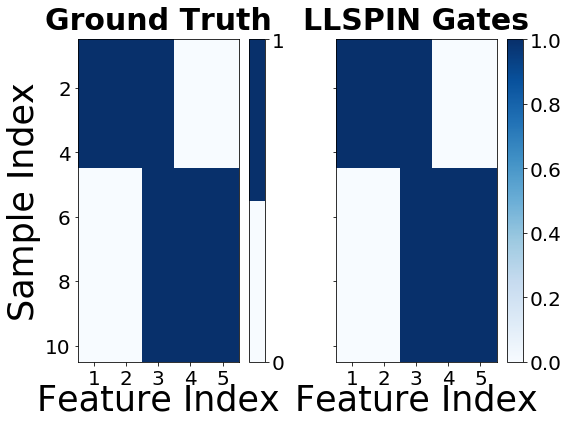

In [42]:
fig, axes = plt.subplots(1, 2,sharex=False, sharey=True,figsize=(8, 6))

sorted_order = np.concatenate((np.where(train_label == 1)[0],np.where(train_label == 2)[0]))

im1 = axes[0].imshow(ref_feat_mat_train[sorted_order,:].astype(int),aspect='auto',cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[0].set_ylabel("Sample Index",fontsize=ylabel_size)
axes[0].set_yticks([1,3,5,7,9])
axes[0].set_yticklabels([2,4,6,8,10],fontsize=ytick_size)
axes[0].set_xticks(list(range(5)))
axes[0].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[0].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)

cbar = fig.colorbar(im1,ax=axes[0], cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

im2 = axes[1].imshow(gate_mat_train[sorted_order,:],aspect='auto',cmap=cmap)
axes[1].set_title("LLSPIN Gates",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[1].set_yticks([1,3,5,7,9])
axes[1].set_yticklabels([2,4,6,8,10],fontsize=ytick_size)
axes[1].set_xticks(list(range(5)))
axes[1].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[1].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)

cbar = fig.colorbar(im2,ax=axes[1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

plt.tight_layout()